# 6-1. 프로젝트: CutMix 또는 Mixup 비교실험 하기

지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지 마세요!

우선 주요 라이브러리 버전을 확인해 볼까요?

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
# TensorFlow and tf.keras
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# Helper libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import json

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1. Augmentation을 적용한 데이터셋 만들기
---
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

#### Q. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?

CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.

### Cutmix 함수

#### 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수

In [4]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

#### 바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수

In [5]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

#### 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수

In [6]:
# mix two labels
# def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
#     image_size_x = image_a.shape[1]
#     image_size_y = image_a.shape[0] 
#     mixed_area = (x_max-x_min)*(y_max-y_min)
#     total_area = image_size_x*image_size_y
#     ratio = tf.cast(mixed_area/total_area, tf.float32)

#     if len(label_a.shape)==0:
#         label_a = tf.one_hot(label_a, num_classes)
#     if len(label_b.shape)==0:
#         label_b = tf.one_hot(label_b, num_classes)
#     mixed_label = (1-ratio)*label_a + ratio*label_b
#     return mixed_label

### 위 함수에서 image_a, image_b 를 참조 하지 못하는 에러 발생 하여 인자로 받을 수 있도록 아래와 같이 수정

In [7]:
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a, image_b, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

#### mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수

In [8]:
# def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
#     mixed_imgs = []
#     mixed_labels = []

#     for i in range(batch_size):
#         image_a = image[i]
#         label_a = label[i]
#         j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
#         image_b = image[j]
#         label_b = label[j]
#         x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
#         mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
#         mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

#     mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
#     mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
#     return mixed_imgs, mixed_labels

### image_a, image_b 까지 전달 할 수 있도록 인자에 추가

In [9]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        # image_a, image_b 까지 전달 할 수 있도록 인자에 추가
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a, image_b))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


### Mixup

#### 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨 섞기

In [10]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

#### 배치 단위의 mixup() 함수

In [11]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [12]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

# def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
#     ds = ds.map(
#         normalize_and_resize_img, 
#         num_parallel_calls=2
#     )
#     if not is_test and with_aug:
#         ds = ds.map(
#             augment
#         )
#     ds = ds.batch(batch_size)
#     if not is_test and with_cutmix:
#         ds = ds.map(
#             cutmix,
#             num_parallel_calls=2
#         )
#     else:
#         ds = ds.map(
#             onehot,
#             num_parallel_calls=2
#         )
#     if not is_test:
#         ds = ds.repeat()
#         ds = ds.shuffle(200)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#     return ds

print('=3')

=3


In [13]:
# mixup 추가 하여 한번에 처리 가능 한 함수 구현
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, 
                               with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
num_classes = ds_info.features["label"].num_classes
print(num_classes)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
120


#### Cutmix 함수 테스트

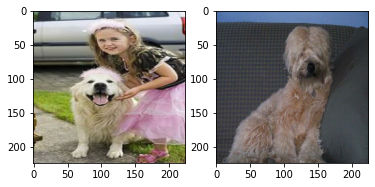

x :  tf.Tensor(113, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(54, shape=(), dtype=int32) tf.Tensor(188, shape=(), dtype=int32)


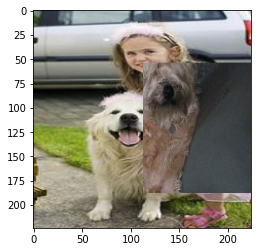

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.29643655, 0.        , 0.        , 0.        ,
       0.        , 0.70356345, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [15]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a, image_b)
mixed_label

#### Mixup 함수 테스트

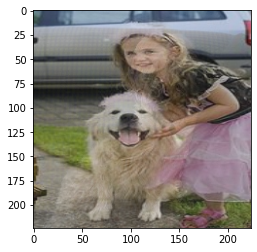

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.33937514 0.         0.
 0.         0.         0.66062486 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [16]:
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

### Cutmix 와 Mixup 데이터셋 만들기

In [17]:
ds_train_cutmix= apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

### 2. 모델 만들기
---
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

#### ResNet-50 직접 구현 코드 (tensorflow 에서 제공한 모델 사용 하여 주석 처리함)

In [18]:
# def basic_block(x, filters, stride=1, use_skip=True):
#     """기본 블록 - ResNet-34와 PlainNet-34에서 사용

#     인자:
#         x: 입력 텐서
#         filters: 합성곱 층의 필터 수
#         stride: 첫 번째 합성곱 층의 스트라이드 값
#         use_skip: skip connection 사용 여부 (ResNet vs PlainNet)

#     반환:
#         블록의 출력 텐서
#     """
#     shortcut = x  # skip connection을 위해 입력 저장

#     # 첫 번째 합성곱 블록
#     x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     # 두 번째 합성곱 블록
#     x = layers.Conv2D(filters, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)

#     if use_skip:  # ResNet의 경우에만 skip connection 적용
#         if stride != 1 or shortcut.shape[-1] != filters:
#             shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
#             shortcut = layers.BatchNormalization()(shortcut)
#         x = layers.Add()([shortcut, x])

#     x = layers.ReLU()(x)
#     return x

In [19]:
# def bottleneck_block(x, filters, stride=1, use_skip=True):
#     """병목 블록 - ResNet-50과 PlainNet-50에서 사용

#     인자:
#         x: 입력 텐서
#         filters: 주 합성곱 층의 필터 수
#         stride: 주 합성곱 층의 스트라이드 값
#         use_skip: skip connection 사용 여부 (ResNet vs PlainNet)

#     반환:
#         블록의 출력 텐서
#     """
#     shortcut = x  # skip connection을 위해 입력 저장

#     # 첫 번째 1x1 합성곱 (차원 감소)
#     x = layers.Conv2D(filters, 1)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     # 3x3 합성곱
#     x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     # 마지막 1x1 합성곱 (차원 확장)
#     x = layers.Conv2D(filters * 4, 1)(x)
#     x = layers.BatchNormalization()(x)

#     if use_skip:  # ResNet의 경우에만 skip connection 적용
#         if stride != 1 or shortcut.shape[-1] != filters * 4:
#             shortcut = layers.Conv2D(filters * 4, 1, strides=stride)(shortcut)
#             shortcut = layers.BatchNormalization()(shortcut)
#         x = layers.Add()([shortcut, x])

#     x = layers.ReLU()(x)
#     return x

In [20]:
# def build_network(is_50=False, use_skip=True):
#     """ResNet 또는 PlainNet 모델 생성

#     인자:
#         is_50: 50층 모델(True) 또는 34층 모델(False) 선택
#         use_skip: ResNet(True) 또는 PlainNet(False) 선택

#     반환:
#         구축된 모델
#     """
#     inputs = Input(shape=(224, 224, 3))
#     # 초기 합성곱 블록
#     x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

#     # 모델 구성 설정
#     if is_50:
#         block_fn = bottleneck_block
#         filters = [64, 128, 256, 512]
#         blocks = [3, 4, 6, 3]
#     else:
#         block_fn = basic_block
#         filters = [64, 128, 256, 512]
#         blocks = [3, 4, 6, 3]

#     # 스테이지별 블록 생성
#     for stage, (filter_size, block_count) in enumerate(zip(filters, blocks)):
#         for block_idx in range(block_count):
#             stride = 2 if block_idx == 0 and stage > 0 else 1
#             x = block_fn(x, filter_size, stride=stride, use_skip=use_skip)

#     # 최종 분류 층
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dense(10, activation='softmax')(x)

#     return Model(inputs, x)

In [21]:
# # 모델 생성 함수들
# def build_resnet(is_50=False):
#     """ResNet 모델 생성"""
#     return build_network(is_50=is_50, use_skip=True)

In [22]:
# def build_plainnet(is_50=False):
#     """PlainNet 모델 생성"""
#     return build_network(is_50=is_50, use_skip=False)

In [23]:
# resnet_50 = build_resnet(is_50=True)
# resnet_50.summary()

#### keras 모델 이용하기
- 함수로 만들어서 사용하도록 수정함

In [24]:
# 모델 생성 함수 정의
def create_resnet50_model(input_shape=(224, 224, 3), num_classes=120):
    return tf.keras.models.Sequential([
        tf.keras.applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=input_shape,
            pooling='avg',
        ),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

In [25]:
# resnet50 = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224,224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation='softmax')
# ])

In [26]:
# aug_resnet50 = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224,224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation='softmax')
# ])

In [27]:
# cutmix_resnet50 = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224,224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation='softmax')
# ])

In [28]:
# mixup_resnet50 = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224,224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation='softmax')
# ])

### 3. 모델 훈련하기
모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

#### Q. sparse_categorical_crossentropy()를 사용하지 못하는 이유가 뭘까요?

우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

### 이진 분류 모델을 위해 출력층 수정(softmax 추가) 및 컴파일
- CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용

In [29]:
# EPOCH = 30 # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# 여덟번째 실험 부터 각각의 epoch 수를 다르게 설정
NO_AUG_EPOCH = 10
AUG_EPOCH = 15
CUTMIX_EPOCH = 300
MIXUP_EPOCH = 300
learning_rate = 0.005

In [30]:
# Learning Rate 스케줄링 콜백 정의
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   # 검증 손실 기준으로 학습률 조정
    factor=0.5,          # 학습률을 50%로 감소
    patience=5,          # 5 에포크 동안 개선되지 않으면 감소
    min_lr=1e-6,         # 학습률의 하한선 설정
    verbose=1            # 학습률 조정 시 메시지 출력
)

In [31]:
# 학습률 로깅 콜백 정의
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # lr = self.model.optimizer.learning_rate.numpy()
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print(f"Epoch {epoch+1}: Learning rate is {lr}")

In [32]:
# 체크포인트 콜백 함수 정의
def create_checkpoint(filepath):
    return ModelCheckpoint(
        filepath=filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        mode="min",
        verbose=1
    )

In [33]:
def plot_metrics(history, model_name):
    """모델의 훈련 및 검증 손실과 정확도를 하나의 행에 그리기"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#     # 손실 그래프 (훈련 + 검증)
#     axes[0].plot(history.history['loss'], label=f'{model_name} (Train)')
#     axes[0].plot(history.history['val_loss'], label=f'{model_name} (Validation)')
#     axes[0].set_title(f'{model_name} Loss (Train & Validation)')
#     axes[0].set_xlabel('Epoch')
#     axes[0].set_ylabel('Loss')
#     axes[0].legend()
#     axes[0].grid(True)

#     # 정확도 그래프 (훈련 + 검증)
#     axes[1].plot(history.history['accuracy'], label=f'{model_name} (Train)')
#     axes[1].plot(history.history['val_accuracy'], label=f'{model_name} (Validation)')
#     axes[1].set_title(f'{model_name} Accuracy (Train & Validation)')
#     axes[1].set_xlabel('Epoch')
#     axes[1].set_ylabel('Accuracy')
#     axes[1].legend()
#     axes[1].grid(True)
    
    # 손실 그래프 (훈련 + 검증)
    axes[0].plot(history['loss'], label=f'{model_name} (Train)')
    axes[0].plot(history['val_loss'], label=f'{model_name} (Validation)')
    axes[0].set_title(f'{model_name} Loss (Train & Validation)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # 정확도 그래프 (훈련 + 검증)
    axes[1].plot(history['accuracy'], label=f'{model_name} (Train)')
    axes[1].plot(history['val_accuracy'], label=f'{model_name} (Validation)')
    axes[1].set_title(f'{model_name} Accuracy (Train & Validation)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [34]:
# 모델 컴파일
def compile_model(model):
    model.compile(
        loss='categorical_crossentropy',
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
        # optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy'],
    )
    return model

In [35]:
# 학습 실행
def train_resnet50(ds_train, ds_test, ds_info, EPOCH, model_name):
    model = create_resnet50_model(num_classes=ds_info.features['label'].num_classes)
    compile_model(model)

    resnet50_checkpoint = create_checkpoint(f"best_{model_name}_model.h5")

    history = model.fit(
        ds_train, 
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=EPOCH,
        validation_data=ds_test,
        verbose=1,
        callbacks=[resnet50_checkpoint, lr_scheduler, LearningRateLogger()],
        use_multiprocessing=True,
    )
    return history

#### ResNet-50 직접 구현 코드 (tensorflow 에서 제공한 모델 사용 하여 주석 처리함)

In [36]:
# # softmax 미사용, SparseCategoricalCrossentropy(from_logits=True)
# def safety_modify_and_compile_model(model, num_classes, learning_rate=0.001):
#     outputs = tf.keras.layers.Dense(num_classes)(model.layers[-2].output)
#     model = tf.keras.Model(inputs=model.input, outputs=outputs)

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=['accuracy']
#     )
#     return model

In [37]:
# # softmax 사용, CategoricalCrossentropy
# def safety_modify_softmax_and_compile_model(model, num_classes, learning_rate=0.001):
#     outputs = layers.Dense(num_classes, activation='softmax')(model.layers[-2].output)
#     model = tf.keras.Model(inputs=model.input, outputs=outputs)

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         loss=tf.keras.losses.CategoricalCrossentropy(),
#         metrics=['accuracy']
#     )
#     return model

In [38]:
# resnet_50 = safety_modify_and_compile_model(resnet_50, num_classes)
# resnet_50.summary()

In [39]:
# print("\nResNet-50 학습 중...")
# resnet50_history = resnet_50.fit(
#     train_ds,
#     validation_data=validation_ds,
#     epochs=EPOCH,
#     verbose=1,
#     # callbacks=callbacks
# )

In [36]:
# 저장된 history 가져오기
def history_conv(history):
    
    return_history = {'loss' : list(history['loss'].values()),
                      'accuracy' : list(history['accuracy'].values()),
                      'val_loss' : list(history['val_loss'].values()),
                      'val_accuracy' : list(history['val_accuracy'].values())}
    
    return return_history

### 'No Augmentation'

In [41]:
history_resnet50 = train_resnet50(ds_train_no_aug, ds_test, ds_info, 
                                         NO_AUG_EPOCH, model_name="resnet50")
# history 저장하기
with open('history/history_resnet50.json', 'w') as f:
    pd.DataFrame(history_resnet50.history).to_json(f)

Epoch 1/10
750/750 [==============================] - 166s 206ms/step - loss: 2.5542 - accuracy: 0.3536 - val_loss: 5.1909 - val_accuracy: 0.0330

Epoch 00001: val_loss improved from inf to 5.19092, saving model to best_resnet50_model.h5
Epoch 1: Learning rate is 0.004999999888241291
Epoch 2/10
750/750 [==============================] - 154s 205ms/step - loss: 1.2622 - accuracy: 0.6337 - val_loss: 2.3579 - val_accuracy: 0.4152

Epoch 00002: val_loss improved from 5.19092 to 2.35793, saving model to best_resnet50_model.h5
Epoch 2: Learning rate is 0.004999999888241291
Epoch 3/10
750/750 [==============================] - 154s 205ms/step - loss: 0.6492 - accuracy: 0.8007 - val_loss: 2.4985 - val_accuracy: 0.4348

Epoch 00003: val_loss did not improve from 2.35793
Epoch 3: Learning rate is 0.004999999888241291
Epoch 4/10
750/750 [==============================] - 154s 205ms/step - loss: 0.2540 - accuracy: 0.9244 - val_loss: 2.1617 - val_accuracy: 0.5146

Epoch 00004: val_loss improved fro

In [42]:
# # 체크포인트 콜백 정의
# resnet50_checkpoint = ModelCheckpoint(
#     filepath="best_resnet50_model.h5",
#     monitor="val_loss",
#     save_best_only=True,
#     save_weights_only=True,
#     mode="min",
#     verbose=1
# )

In [43]:
# resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Optimizer를 Adam으로 변경
#     metrics=['accuracy'],
# )

# history_resnet50 = resnet50.fit(
#     ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     callbacks=[resnet50_checkpoint, lr_scheduler, LearningRateLogger()],
#     use_multiprocessing=True,
# )

resnet50


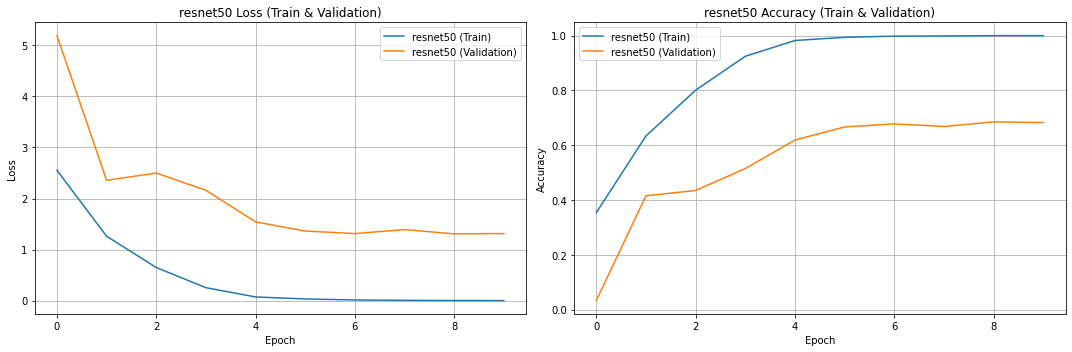

In [37]:
# 저장된 history 가져오기
with open('history/history_resnet50.json', 'r') as f:
    read_history = json.load(f)
    
read_history_resnet50 = history_conv(read_history)

print("resnet50")
plot_metrics(read_history_resnet50, 'resnet50')

### 'With Augmentation'

In [45]:
history_aug_resnet50 = train_resnet50(ds_train_aug, ds_test, ds_info, 
                                      AUG_EPOCH, model_name="aug_resnet50")
# history 저장하기
with open('history/history_aug_resnet50.json', 'w') as f:
    pd.DataFrame(history_aug_resnet50.history).to_json(f)

Epoch 1/15
  6/750 [..............................] - ETA: 2:06 - loss: 5.3685 - accuracy: 0.0104WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0803s vs `on_train_batch_end` time: 0.0973s). Check your callbacks.


750/750 [==============================] - 162s 207ms/step - loss: 2.6154 - accuracy: 0.3364 - val_loss: 5.0565 - val_accuracy: 0.0318

Epoch 00001: val_loss improved from inf to 5.05652, saving model to best_aug_resnet50_model.h5
Epoch 1: Learning rate is 0.004999999888241291
Epoch 2/15
750/750 [==============================] - 154s 205ms/step - loss: 1.4962 - accuracy: 0.5718 - val_loss: 2.3351 - val_accuracy: 0.4088

Epoch 00002: val_loss improved from 5.05652 to 2.33506, saving model to best_aug_resnet50_model.h5
Epoch 2: Learning rate is 0.004999999888241291
Epoch 3/15
750/750 [==============================] - 154s 205ms/step - loss: 0.9748 - accuracy: 0.7065 - val_loss: 3.2244 - val_accuracy: 0.2921

Epoch 00003: val_loss did not improve from 2.33506
Epoch 3: Learning rate is 0.004999999888241291
Epoch 4/15
750/750 [==============================] - 154s 205ms/step - loss: 0.6324 - accuracy: 0.8046 - val_loss: 1.8111 - val_accuracy: 0.5436

Epoch 00004: val_loss improved from 2

In [46]:
# # 체크포인트 콜백 정의
# aug_resnet50_checkpoint = ModelCheckpoint(
#     filepath="best_aug_resnet50_model.h5",
#     monitor="val_loss",
#     save_best_only=True,
#     save_weights_only=True,
#     mode="min",
#     verbose=1
# )

In [47]:
# aug_resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Optimizer를 Adam으로 변경
#     metrics=['accuracy'],
# )

# history_aug_resnet50 = aug_resnet50.fit(
#     ds_train_aug, # augmentation 적용한 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     callbacks=[aug_resnet50_checkpoint, lr_scheduler, LearningRateLogger()],
#     use_multiprocessing=True,
# )

aug_resnet50


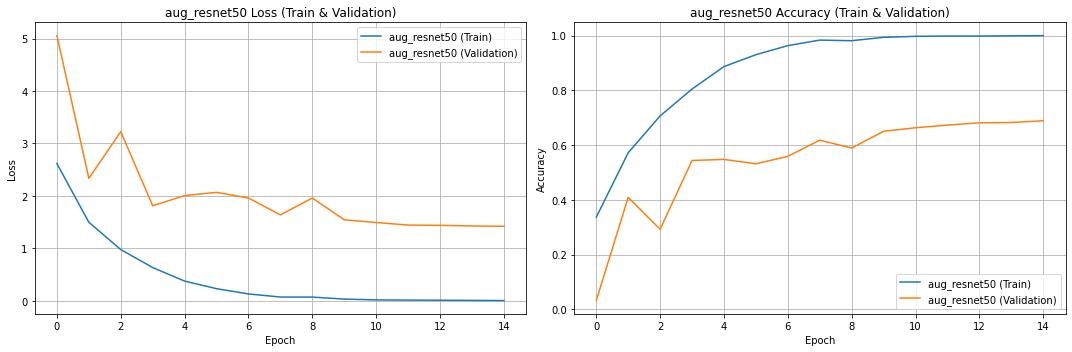

In [38]:
# 저장된 history 가져오기
with open('history/history_aug_resnet50.json', 'r') as f:
    read_history = json.load(f)
    
read_history_aug_resnet50 = history_conv(read_history)

print("aug_resnet50")
plot_metrics(read_history_aug_resnet50, 'aug_resnet50')

### 'Augmentation + Cutmix'

In [49]:
history_cutmix_resnet50 = train_resnet50(ds_train_cutmix, ds_test, ds_info, 
                                         CUTMIX_EPOCH, model_name="cutmix_resnet50")
# history 저장하기
with open('history/history_cutmix_resnet50.json', 'w') as f:
    pd.DataFrame(history_cutmix_resnet50.history).to_json(f)

Epoch 1/300
  6/750 [..............................] - ETA: 2:08 - loss: 5.2415 - accuracy: 0.0208WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0698s vs `on_train_batch_end` time: 0.1081s). Check your callbacks.


750/750 [==============================] - 165s 208ms/step - loss: 3.8818 - accuracy: 0.1835 - val_loss: 3.8350 - val_accuracy: 0.1349

Epoch 00001: val_loss improved from inf to 3.83500, saving model to best_cutmix_resnet50_model.h5
Epoch 1: Learning rate is 0.004999999888241291
Epoch 2/300
750/750 [==============================] - 155s 206ms/step - loss: 3.1719 - accuracy: 0.3451 - val_loss: 2.4302 - val_accuracy: 0.3719

Epoch 00002: val_loss improved from 3.83500 to 2.43018, saving model to best_cutmix_resnet50_model.h5
Epoch 2: Learning rate is 0.004999999888241291
Epoch 3/300
750/750 [==============================] - 157s 209ms/step - loss: 2.9021 - accuracy: 0.4289 - val_loss: 2.1552 - val_accuracy: 0.4439

Epoch 00003: val_loss improved from 2.43018 to 2.15524, saving model to best_cutmix_resnet50_model.h5
Epoch 3: Learning rate is 0.004999999888241291
Epoch 4/300
750/750 [==============================] - 155s 207ms/step - loss: 2.6976 - accuracy: 0.4845 - val_loss: 1.9553 -

750/750 [==============================] - 160s 213ms/step - loss: 1.1659 - accuracy: 0.8730 - val_loss: 1.4382 - val_accuracy: 0.7039

Epoch 00062: val_loss did not improve from 1.41523
Epoch 62: Learning rate is 1.9531249563442543e-05
Epoch 63/300
750/750 [==============================] - 160s 214ms/step - loss: 1.1630 - accuracy: 0.8668 - val_loss: 1.4298 - val_accuracy: 0.7036

Epoch 00063: val_loss did not improve from 1.41523
Epoch 63: Learning rate is 1.9531249563442543e-05
Epoch 64/300
750/750 [==============================] - 159s 212ms/step - loss: 1.1705 - accuracy: 0.8687 - val_loss: 1.4287 - val_accuracy: 0.7030

Epoch 00064: val_loss did not improve from 1.41523
Epoch 64: Learning rate is 1.9531249563442543e-05
Epoch 65/300
750/750 [==============================] - 157s 210ms/step - loss: 1.1693 - accuracy: 0.8662 - val_loss: 1.4406 - val_accuracy: 0.7024

Epoch 00065: val_loss did not improve from 1.41523
Epoch 65: Learning rate is 1.9531249563442543e-05
Epoch 66/300


750/750 [==============================] - 156s 207ms/step - loss: 1.1640 - accuracy: 0.8685 - val_loss: 1.4399 - val_accuracy: 0.7043

Epoch 00126: val_loss did not improve from 1.41523
Epoch 126: Learning rate is 9.999999974752427e-07
Epoch 127/300
750/750 [==============================] - 171s 228ms/step - loss: 1.1719 - accuracy: 0.8634 - val_loss: 1.4332 - val_accuracy: 0.7038

Epoch 00127: val_loss did not improve from 1.41523
Epoch 127: Learning rate is 9.999999974752427e-07
Epoch 128/300
750/750 [==============================] - 156s 208ms/step - loss: 1.1621 - accuracy: 0.8648 - val_loss: 1.4381 - val_accuracy: 0.7029

Epoch 00128: val_loss did not improve from 1.41523
Epoch 128: Learning rate is 9.999999974752427e-07
Epoch 129/300
750/750 [==============================] - 156s 209ms/step - loss: 1.1564 - accuracy: 0.8672 - val_loss: 1.4314 - val_accuracy: 0.7035

Epoch 00129: val_loss did not improve from 1.41523
Epoch 129: Learning rate is 9.999999974752427e-07
Epoch 130/

750/750 [==============================] - 156s 208ms/step - loss: 1.1602 - accuracy: 0.8722 - val_loss: 1.4326 - val_accuracy: 0.7025

Epoch 00159: val_loss did not improve from 1.41523
Epoch 159: Learning rate is 9.999999974752427e-07
Epoch 160/300
750/750 [==============================] - 157s 209ms/step - loss: 1.1675 - accuracy: 0.8717 - val_loss: 1.4322 - val_accuracy: 0.7031

Epoch 00160: val_loss did not improve from 1.41523
Epoch 160: Learning rate is 9.999999974752427e-07
Epoch 161/300
750/750 [==============================] - 163s 217ms/step - loss: 1.1989 - accuracy: 0.8565 - val_loss: 1.4386 - val_accuracy: 0.7027

Epoch 00161: val_loss did not improve from 1.41523
Epoch 161: Learning rate is 9.999999974752427e-07
Epoch 162/300
750/750 [==============================] - 160s 213ms/step - loss: 1.1666 - accuracy: 0.8702 - val_loss: 1.4342 - val_accuracy: 0.7031

Epoch 00162: val_loss did not improve from 1.41523
Epoch 162: Learning rate is 9.999999974752427e-07
Epoch 163/

750/750 [==============================] - 155s 207ms/step - loss: 1.1620 - accuracy: 0.8702 - val_loss: 1.4305 - val_accuracy: 0.7043

Epoch 00192: val_loss did not improve from 1.41523
Epoch 192: Learning rate is 9.999999974752427e-07
Epoch 193/300
750/750 [==============================] - 156s 208ms/step - loss: 1.1590 - accuracy: 0.8708 - val_loss: 1.4368 - val_accuracy: 0.7031

Epoch 00193: val_loss did not improve from 1.41523
Epoch 193: Learning rate is 9.999999974752427e-07
Epoch 194/300
750/750 [==============================] - 157s 209ms/step - loss: 1.1616 - accuracy: 0.8673 - val_loss: 1.4323 - val_accuracy: 0.7044

Epoch 00194: val_loss did not improve from 1.41523
Epoch 194: Learning rate is 9.999999974752427e-07
Epoch 195/300
750/750 [==============================] - 156s 208ms/step - loss: 1.1554 - accuracy: 0.8618 - val_loss: 1.4303 - val_accuracy: 0.7028

Epoch 00195: val_loss did not improve from 1.41523
Epoch 195: Learning rate is 9.999999974752427e-07
Epoch 196/

750/750 [==============================] - 156s 208ms/step - loss: 1.1546 - accuracy: 0.8773 - val_loss: 1.4237 - val_accuracy: 0.7051

Epoch 00225: val_loss did not improve from 1.41523
Epoch 225: Learning rate is 9.999999974752427e-07
Epoch 226/300
750/750 [==============================] - 155s 207ms/step - loss: 1.1655 - accuracy: 0.8680 - val_loss: 1.4290 - val_accuracy: 0.7037

Epoch 00226: val_loss did not improve from 1.41523
Epoch 226: Learning rate is 9.999999974752427e-07
Epoch 227/300
750/750 [==============================] - 155s 207ms/step - loss: 1.1698 - accuracy: 0.8635 - val_loss: 1.4329 - val_accuracy: 0.7027

Epoch 00227: val_loss did not improve from 1.41523
Epoch 227: Learning rate is 9.999999974752427e-07
Epoch 228/300
750/750 [==============================] - 155s 207ms/step - loss: 1.1615 - accuracy: 0.8713 - val_loss: 1.4264 - val_accuracy: 0.7032

Epoch 00228: val_loss did not improve from 1.41523
Epoch 228: Learning rate is 9.999999974752427e-07
Epoch 229/

750/750 [==============================] - 157s 209ms/step - loss: 1.1701 - accuracy: 0.8697 - val_loss: 1.4248 - val_accuracy: 0.7044

Epoch 00258: val_loss did not improve from 1.41523
Epoch 258: Learning rate is 9.999999974752427e-07
Epoch 259/300
750/750 [==============================] - 156s 208ms/step - loss: 1.1604 - accuracy: 0.8737 - val_loss: 1.4239 - val_accuracy: 0.7043

Epoch 00259: val_loss did not improve from 1.41523
Epoch 259: Learning rate is 9.999999974752427e-07
Epoch 260/300
750/750 [==============================] - 156s 208ms/step - loss: 1.1693 - accuracy: 0.8640 - val_loss: 1.4247 - val_accuracy: 0.7037

Epoch 00260: val_loss did not improve from 1.41523
Epoch 260: Learning rate is 9.999999974752427e-07
Epoch 261/300
750/750 [==============================] - 156s 208ms/step - loss: 1.1772 - accuracy: 0.8676 - val_loss: 1.4363 - val_accuracy: 0.7043

Epoch 00261: val_loss did not improve from 1.41523
Epoch 261: Learning rate is 9.999999974752427e-07
Epoch 262/

750/750 [==============================] - 156s 207ms/step - loss: 1.1580 - accuracy: 0.8691 - val_loss: 1.4253 - val_accuracy: 0.7043

Epoch 00291: val_loss did not improve from 1.41523
Epoch 291: Learning rate is 9.999999974752427e-07
Epoch 292/300
750/750 [==============================] - 156s 209ms/step - loss: 1.1860 - accuracy: 0.8614 - val_loss: 1.4343 - val_accuracy: 0.7035

Epoch 00292: val_loss did not improve from 1.41523
Epoch 292: Learning rate is 9.999999974752427e-07
Epoch 293/300
750/750 [==============================] - 157s 209ms/step - loss: 1.1683 - accuracy: 0.8706 - val_loss: 1.4293 - val_accuracy: 0.7038

Epoch 00293: val_loss did not improve from 1.41523
Epoch 293: Learning rate is 9.999999974752427e-07
Epoch 294/300
750/750 [==============================] - 156s 208ms/step - loss: 1.1555 - accuracy: 0.8712 - val_loss: 1.4255 - val_accuracy: 0.7046

Epoch 00294: val_loss did not improve from 1.41523
Epoch 294: Learning rate is 9.999999974752427e-07
Epoch 295/

In [50]:
# # 체크포인트 콜백 정의
# cutmix_resnet50_checkpoint = ModelCheckpoint(
#     filepath="best_cutmix_resnet50_model.h5",
#     monitor="val_loss",
#     save_best_only=True,
#     save_weights_only=True,
#     mode="min",
#     verbose=1
# )

In [51]:
# cutmix_resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Optimizer를 Adam으로 변경
#     metrics=['accuracy'],
# )

# history_cutmix_resnet50 = cutmix_resnet50.fit(
#     ds_train_cutmix, # CutMix 적용한 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     callbacks=[cutmix_resnet50_checkpoint, lr_scheduler, LearningRateLogger()],
#     use_multiprocessing=True,
# )

cutmix_resnet50


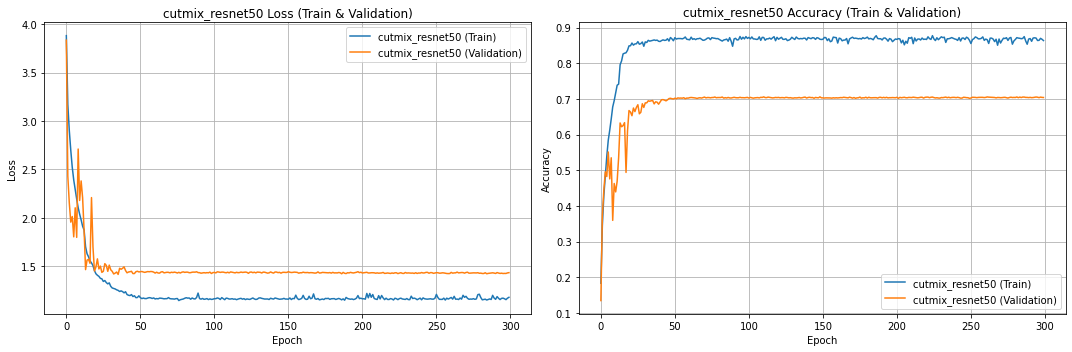

In [39]:
# 저장된 history 가져오기
with open('history/history_cutmix_resnet50.json', 'r') as f:
    read_history = json.load(f)
    
read_history_cutmix_resnet50 = history_conv(read_history)

print("cutmix_resnet50")
plot_metrics(read_history_cutmix_resnet50, 'cutmix_resnet50')

### 'Augmentation + Mixup'

In [44]:
history_mixup_resnet50 = train_resnet50(ds_train_mixup, ds_test, ds_info, 
                                        MIXUP_EPOCH, model_name="mixup_resnet50")
# history 저장하기
with open('history/history_mixup_resnet50.json', 'w') as f:
    pd.DataFrame(history_mixup_resnet50.history).to_json(f)

94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/300
  6/750 [..............................] - ETA: 1:58 - loss: 5.0536 - accuracy: 0.0104  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0661s vs `on_train_batch_end` time: 0.0782s). Check your callbacks.


750/750 [==============================] - 160s 195ms/step - loss: 3.8485 - accuracy: 0.1941 - val_loss: 3.6874 - val_accuracy: 0.1517

Epoch 00001: val_loss improved from inf to 3.68737, saving model to best_mixup_resnet50_model.h5
Epoch 1: Learning rate is 0.004999999888241291
Epoch 2/300
750/750 [==============================] - 152s 202ms/step - loss: 3.1456 - accuracy: 0.3717 - val_loss: 3.2522 - val_accuracy: 0.2452

Epoch 00002: val_loss improved from 3.68737 to 3.25215, saving model to best_mixup_resnet50_model.h5
Epoch 2: Learning rate is 0.004999999888241291
Epoch 3/300
750/750 [==============================] - 151s 201ms/step - loss: 2.8660 - accuracy: 0.4700 - val_loss: 2.7876 - val_accuracy: 0.3224

Epoch 00003: val_loss improved from 3.25215 to 2.78760, saving model to best_mixup_resnet50_model.h5
Epoch 3: Learning rate is 0.004999999888241291
Epoch 4/300
750/750 [==============================] - 155s 207ms/step - loss: 2.6677 - accuracy: 0.5350 - val_loss: 2.1597 - va

750/750 [==============================] - 151s 202ms/step - loss: 1.4178 - accuracy: 0.9036 - val_loss: 1.3710 - val_accuracy: 0.6855

Epoch 00064: val_loss did not improve from 1.34416
Epoch 64: Learning rate is 9.765624781721272e-06
Epoch 65/300
750/750 [==============================] - 151s 201ms/step - loss: 1.3945 - accuracy: 0.9065 - val_loss: 1.3719 - val_accuracy: 0.6852

Epoch 00065: val_loss did not improve from 1.34416

Epoch 00065: ReduceLROnPlateau reducing learning rate to 4.882812390860636e-06.
Epoch 65: Learning rate is 4.882812390860636e-06
Epoch 66/300
750/750 [==============================] - 151s 201ms/step - loss: 1.4060 - accuracy: 0.8999 - val_loss: 1.3702 - val_accuracy: 0.6852

Epoch 00066: val_loss did not improve from 1.34416
Epoch 66: Learning rate is 4.882812390860636e-06
Epoch 67/300
750/750 [==============================] - 151s 201ms/step - loss: 1.3972 - accuracy: 0.9016 - val_loss: 1.3746 - val_accuracy: 0.6856

Epoch 00067: val_loss did not improv

750/750 [==============================] - 151s 202ms/step - loss: 1.4046 - accuracy: 0.8969 - val_loss: 1.3726 - val_accuracy: 0.6844

Epoch 00096: val_loss did not improve from 1.34416
Epoch 96: Learning rate is 9.999999974752427e-07
Epoch 97/300
750/750 [==============================] - 151s 201ms/step - loss: 1.4186 - accuracy: 0.8978 - val_loss: 1.3693 - val_accuracy: 0.6868

Epoch 00097: val_loss did not improve from 1.34416
Epoch 97: Learning rate is 9.999999974752427e-07
Epoch 98/300
750/750 [==============================] - 167s 223ms/step - loss: 1.4155 - accuracy: 0.8982 - val_loss: 1.3703 - val_accuracy: 0.6858

Epoch 00098: val_loss did not improve from 1.34416
Epoch 98: Learning rate is 9.999999974752427e-07
Epoch 99/300
750/750 [==============================] - 151s 202ms/step - loss: 1.3975 - accuracy: 0.9024 - val_loss: 1.3728 - val_accuracy: 0.6855

Epoch 00099: val_loss did not improve from 1.34416
Epoch 99: Learning rate is 9.999999974752427e-07
Epoch 100/300
750

750/750 [==============================] - 152s 202ms/step - loss: 1.3983 - accuracy: 0.9046 - val_loss: 1.3731 - val_accuracy: 0.6859

Epoch 00130: val_loss did not improve from 1.34416
Epoch 130: Learning rate is 9.999999974752427e-07
Epoch 131/300
750/750 [==============================] - 152s 202ms/step - loss: 1.4060 - accuracy: 0.9038 - val_loss: 1.3740 - val_accuracy: 0.6856

Epoch 00131: val_loss did not improve from 1.34416
Epoch 131: Learning rate is 9.999999974752427e-07
Epoch 132/300
750/750 [==============================] - 152s 203ms/step - loss: 1.3997 - accuracy: 0.8996 - val_loss: 1.3717 - val_accuracy: 0.6854

Epoch 00132: val_loss did not improve from 1.34416
Epoch 132: Learning rate is 9.999999974752427e-07
Epoch 133/300
750/750 [==============================] - 151s 202ms/step - loss: 1.4044 - accuracy: 0.9037 - val_loss: 1.3683 - val_accuracy: 0.6858

Epoch 00133: val_loss did not improve from 1.34416
Epoch 133: Learning rate is 9.999999974752427e-07
Epoch 134/

750/750 [==============================] - 151s 201ms/step - loss: 1.3929 - accuracy: 0.8982 - val_loss: 1.3703 - val_accuracy: 0.6868

Epoch 00163: val_loss did not improve from 1.34416
Epoch 163: Learning rate is 9.999999974752427e-07
Epoch 164/300
750/750 [==============================] - 152s 203ms/step - loss: 1.4064 - accuracy: 0.9008 - val_loss: 1.3728 - val_accuracy: 0.6852

Epoch 00164: val_loss did not improve from 1.34416
Epoch 164: Learning rate is 9.999999974752427e-07
Epoch 165/300
750/750 [==============================] - 167s 223ms/step - loss: 1.4082 - accuracy: 0.9068 - val_loss: 1.3715 - val_accuracy: 0.6858

Epoch 00165: val_loss did not improve from 1.34416
Epoch 165: Learning rate is 9.999999974752427e-07
Epoch 166/300
750/750 [==============================] - 152s 203ms/step - loss: 1.4021 - accuracy: 0.9013 - val_loss: 1.3738 - val_accuracy: 0.6855

Epoch 00166: val_loss did not improve from 1.34416
Epoch 166: Learning rate is 9.999999974752427e-07
Epoch 167/

750/750 [==============================] - 154s 206ms/step - loss: 1.4130 - accuracy: 0.8974 - val_loss: 1.3623 - val_accuracy: 0.6862

Epoch 00196: val_loss did not improve from 1.34416
Epoch 196: Learning rate is 9.999999974752427e-07
Epoch 197/300
750/750 [==============================] - 153s 204ms/step - loss: 1.3959 - accuracy: 0.9038 - val_loss: 1.3691 - val_accuracy: 0.6852

Epoch 00197: val_loss did not improve from 1.34416
Epoch 197: Learning rate is 9.999999974752427e-07
Epoch 198/300
750/750 [==============================] - 152s 203ms/step - loss: 1.4065 - accuracy: 0.9028 - val_loss: 1.3703 - val_accuracy: 0.6860

Epoch 00198: val_loss did not improve from 1.34416
Epoch 198: Learning rate is 9.999999974752427e-07
Epoch 199/300
750/750 [==============================] - 152s 202ms/step - loss: 1.4036 - accuracy: 0.9039 - val_loss: 1.3709 - val_accuracy: 0.6860

Epoch 00199: val_loss did not improve from 1.34416
Epoch 199: Learning rate is 9.999999974752427e-07
Epoch 200/

750/750 [==============================] - 151s 201ms/step - loss: 1.3914 - accuracy: 0.9043 - val_loss: 1.3713 - val_accuracy: 0.6860

Epoch 00229: val_loss did not improve from 1.34416
Epoch 229: Learning rate is 9.999999974752427e-07
Epoch 230/300
750/750 [==============================] - 151s 201ms/step - loss: 1.4010 - accuracy: 0.9082 - val_loss: 1.3689 - val_accuracy: 0.6849

Epoch 00230: val_loss did not improve from 1.34416
Epoch 230: Learning rate is 9.999999974752427e-07
Epoch 231/300
750/750 [==============================] - 151s 202ms/step - loss: 1.3993 - accuracy: 0.9019 - val_loss: 1.3665 - val_accuracy: 0.6858

Epoch 00231: val_loss did not improve from 1.34416
Epoch 231: Learning rate is 9.999999974752427e-07
Epoch 232/300
750/750 [==============================] - 151s 202ms/step - loss: 1.4098 - accuracy: 0.9059 - val_loss: 1.3689 - val_accuracy: 0.6863

Epoch 00232: val_loss did not improve from 1.34416
Epoch 232: Learning rate is 9.999999974752427e-07
Epoch 233/

750/750 [==============================] - 154s 205ms/step - loss: 1.3912 - accuracy: 0.9050 - val_loss: 1.3658 - val_accuracy: 0.6856

Epoch 00263: val_loss did not improve from 1.34416
Epoch 263: Learning rate is 9.999999974752427e-07
Epoch 264/300
750/750 [==============================] - 153s 203ms/step - loss: 1.4082 - accuracy: 0.9022 - val_loss: 1.3723 - val_accuracy: 0.6865

Epoch 00264: val_loss did not improve from 1.34416
Epoch 264: Learning rate is 9.999999974752427e-07
Epoch 265/300
750/750 [==============================] - 152s 202ms/step - loss: 1.4020 - accuracy: 0.9062 - val_loss: 1.3703 - val_accuracy: 0.6858

Epoch 00265: val_loss did not improve from 1.34416
Epoch 265: Learning rate is 9.999999974752427e-07
Epoch 266/300
750/750 [==============================] - 151s 201ms/step - loss: 1.4112 - accuracy: 0.9022 - val_loss: 1.3670 - val_accuracy: 0.6847

Epoch 00266: val_loss did not improve from 1.34416
Epoch 266: Learning rate is 9.999999974752427e-07
Epoch 267/

750/750 [==============================] - 167s 222ms/step - loss: 1.3870 - accuracy: 0.9005 - val_loss: 1.3713 - val_accuracy: 0.6865

Epoch 00296: val_loss did not improve from 1.34416
Epoch 296: Learning rate is 9.999999974752427e-07
Epoch 297/300
750/750 [==============================] - 150s 200ms/step - loss: 1.4090 - accuracy: 0.8961 - val_loss: 1.3696 - val_accuracy: 0.6855

Epoch 00297: val_loss did not improve from 1.34416
Epoch 297: Learning rate is 9.999999974752427e-07
Epoch 298/300
750/750 [==============================] - 150s 200ms/step - loss: 1.3939 - accuracy: 0.9047 - val_loss: 1.3696 - val_accuracy: 0.6856

Epoch 00298: val_loss did not improve from 1.34416
Epoch 298: Learning rate is 9.999999974752427e-07
Epoch 299/300
750/750 [==============================] - 150s 200ms/step - loss: 1.4113 - accuracy: 0.8957 - val_loss: 1.3685 - val_accuracy: 0.6858

Epoch 00299: val_loss did not improve from 1.34416
Epoch 299: Learning rate is 9.999999974752427e-07
Epoch 300/

In [ ]:
# # 체크포인트 콜백 정의
# mixup_resnet50_checkpoint = ModelCheckpoint(
#     filepath="best_mixup_resnet50_model.h5",
#     monitor="val_loss",
#     save_best_only=True,
#     save_weights_only=True,
#     mode="min",
#     verbose=1
# )

In [ ]:
# mixup_resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Optimizer를 Adam으로 변경
#     metrics=['accuracy'],
# )

# history_mixup_resnet50 = mixup_resnet50.fit(
#     ds_train_mixup, # Mixup 적용한 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     callbacks=[mixup_resnet50_checkpoint, lr_scheduler, LearningRateLogger()],
#     use_multiprocessing=True,
# )

mixup_resnet50


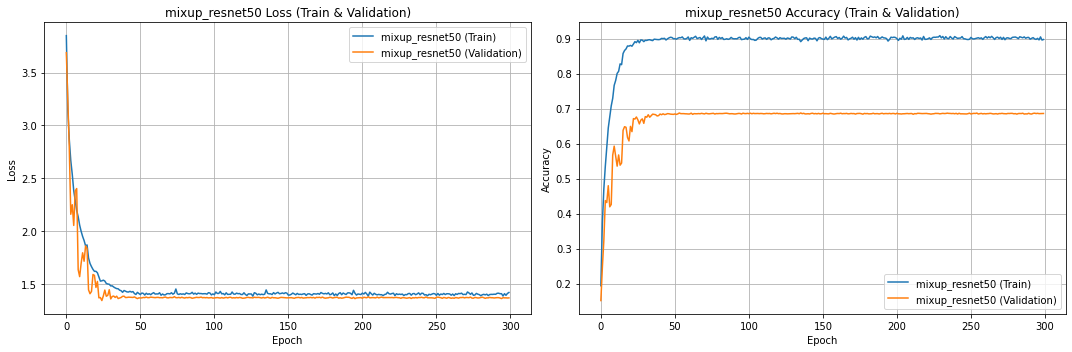

In [40]:
# 저장된 history 가져오기
with open('history/history_mixup_resnet50.json', 'r') as f:
    read_history = json.load(f)
    
read_history_mixup_resnet50 = history_conv(read_history)

print("mixup_resnet50")
plot_metrics(read_history_mixup_resnet50, 'mixup_resnet50')

### 4. 훈련 과정 시각화하기
---
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

In [43]:
import matplotlib.pyplot as plt

def plot_comparison(history_dict, title="Validation Metrics for Different Techniques"):
    """
    여러 학습 이력에 대한 검증 손실과 정확도를 하나의 그림에 시각화합니다.

    매개변수:
    history_dict: 딕셔너리로, 키는 기법 이름이고 값은 Keras History 객체입니다.
    title: 플롯의 제목.
    """
    plt.figure(figsize=(12, 16))

    # 검증 손실 플롯
    plt.subplot(2, 1, 1)
    for label, history in history_dict.items():
        plt.plot(history['val_loss'], label=f'{label} Loss')
    plt.title('Validation Loss')  # 제목: 검증 손실
    plt.xlabel('Epoch')  # x축 레이블: Epoch
    plt.ylabel('Loss')  # y축 레이블: Loss
    plt.legend()  # 범례 추가

    # 검증 정확도 플롯
    plt.subplot(2, 1, 2)
    for label, history in history_dict.items():
        plt.plot(history['val_accuracy'], label=f'{label} Accuracy')
    plt.title('Validation Accuracy')  # 제목: 검증 정확도
    plt.xlabel('Epoch')  # x축 레이블: Epoch
    plt.ylabel('Accuracy')  # y축 레이블: Accuracy
    plt.legend()  # 범례 추가

    plt.suptitle(title)  # 전체 제목 설정
    plt.tight_layout()  # 레이아웃 조정
    plt.show()

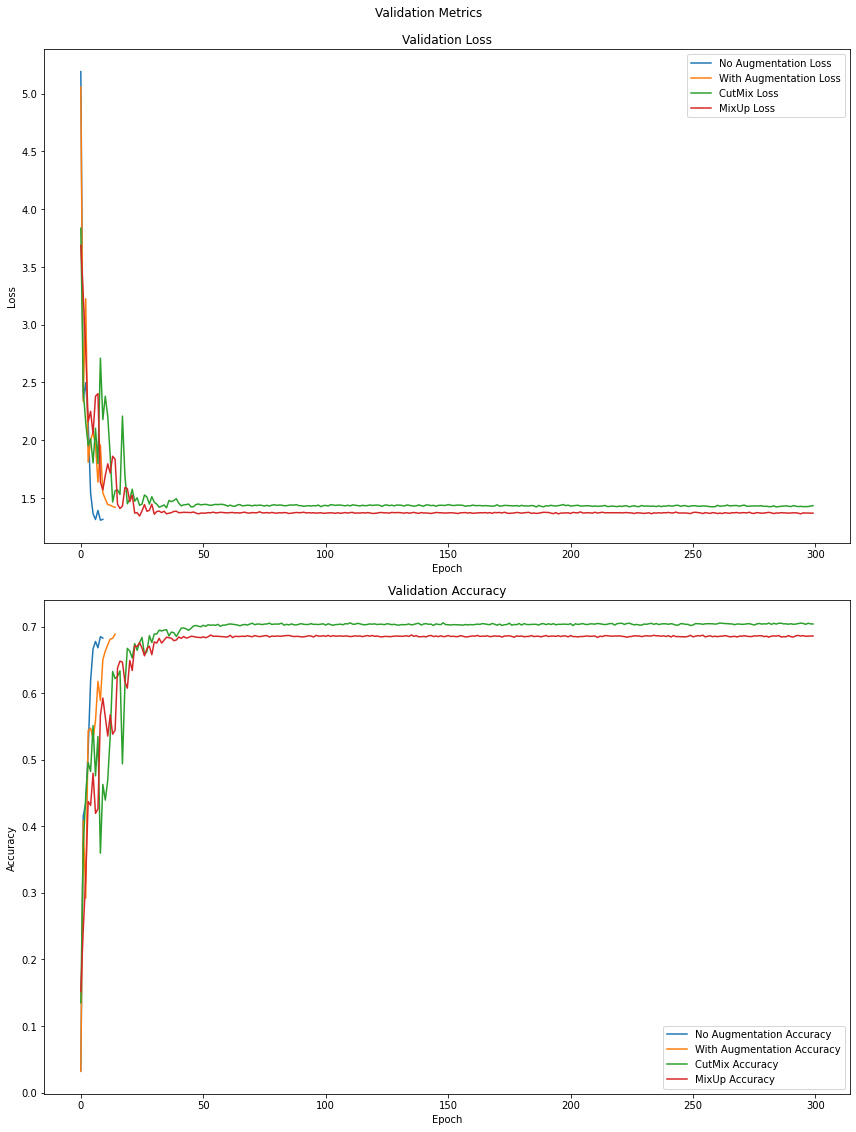

In [44]:
history_dict = {
    "No Augmentation": read_history_resnet50,
    "With Augmentation": read_history_aug_resnet50,
    "CutMix": read_history_cutmix_resnet50,
    "MixUp": read_history_mixup_resnet50
}
plot_comparison(history_dict, title="Validation Metrics\n")

### 5. Augmentation에 의한 모델 성능 비교
---
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

In [48]:
def create_comparison_tables(history_resnet50, history_aug_resnet50,
                           history_cutmix_resnet50, history_mixup_resnet50):

    # 각 모델의 최고 validation accuracy
    accuracies = {
        'resnet50_no_aug': max(history_resnet50['val_accuracy']) * 100,
        'resnet50_aug': max(history_aug_resnet50['val_accuracy']) * 100,
        'resnet50_cutMix': max(history_cutmix_resnet50['val_accuracy']) * 100,
        'resnet50_mixup': max(history_mixup_resnet50['val_accuracy']) * 100
    }

    # 1. resnet50_no_aug vs resnet50_aug
    print("\nresnet50_no_aug vs resnet50_aug - Validation Accuracy (%)")
    print("-" * 40)
    print(f"{'Model':<15} {'Accuracy':>15}")
    print("-" * 40)
    print(f"{'resnet50_no_aug':<15} {accuracies['resnet50_no_aug']:>15.2f}")
    print(f"{'resnet50_aug':<15} {accuracies['resnet50_aug']:>15.2f}")
    print("-" * 40)

    # 2. resnet50_aug vs resnet50_cutMix
    print("\nresnet50_aug vs resnet50_cutMix - Validation Accuracy (%)")
    print("-" * 40)
    print(f"{'Model':<15} {'Accuracy':>15}")
    print("-" * 40)
    print(f"{'resnet50_aug':<15} {accuracies['resnet50_aug']:>15.2f}")
    print(f"{'resnet50_cutMix':<15} {accuracies['resnet50_cutMix']:>15.2f}")
    print("-" * 40)

    # 3. resnet50_aug vs resnet50_mixup
    print("\nresnet50_aug vs resnet50_mixup - Validation Accuracy (%)")
    print("-" * 40)
    print(f"{'Model':<15} {'Accuracy':>15}")
    print("-" * 40)
    print(f"{'resnet50_aug':<15} {accuracies['resnet50_aug']:>15.2f}")
    print(f"{'resnet50_mixup':<15} {accuracies['resnet50_mixup']:>15.2f}")
    print("-" * 40)
    
    # 4. resnet50_cutMix vs resnet50_mixup
    print("\nresnet50_cutMix vs resnet50_mixup - Validation Accuracy (%)")
    print("-" * 40)
    print(f"{'Model':<15} {'Accuracy':>15}")
    print("-" * 40)
    print(f"{'resnet50_cutMix':<15} {accuracies['resnet50_cutMix']:>15.2f}")
    print(f"{'resnet50_mixup':<15} {accuracies['resnet50_mixup']:>15.2f}")
    print("-" * 40)

In [49]:
# 결과표 생성
create_comparison_tables(read_history_resnet50, read_history_aug_resnet50,
                           read_history_cutmix_resnet50, read_history_mixup_resnet50)


resnet50_no_aug vs resnet50_aug - Validation Accuracy (%)
----------------------------------------
Model                  Accuracy
----------------------------------------
resnet50_no_aug           68.49
resnet50_aug              68.87
----------------------------------------

resnet50_aug vs resnet50_cutMix - Validation Accuracy (%)
----------------------------------------
Model                  Accuracy
----------------------------------------
resnet50_aug              68.87
resnet50_cutMix           70.57
----------------------------------------

resnet50_aug vs resnet50_mixup - Validation Accuracy (%)
----------------------------------------
Model                  Accuracy
----------------------------------------
resnet50_aug              68.87
resnet50_mixup            68.75
----------------------------------------

resnet50_cutMix vs resnet50_mixup - Validation Accuracy (%)
----------------------------------------
Model                  Accuracy
---------------------------------

### 첫 번째 실험
- EPOCH = 30
- SGD
- learning_rate = 0.01

### 두 번째 실험
- lr_scheduler, LearningRateLogger 추가
- EPOCH = 50 변경
- Adam 변경
- 초기 learning_rate=0.05 로 설정

### 세 번째 실험
- 초기 learning_rate=0.01 로 설정
- Code-Refactoring(모델생성, 컴파일, train 로직 함수화)

### 네 번째 실험
- optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

### 다섯번째 실험
- EPOCH = 40 으로 변경
- learning_rate = 0.05로 변경

### 여섯번째 실험
- EPOCH = 50 로 변경
- learning_rate = 0.005 로 변경

### 일곱번째 실험
- Adam 변경
- learning_rate = 0.001 로 변경

### 여덟번째 실험
- 여덟번째 실험 부터 각각의 epoch 수를 다르게 설정
- NO_AUG_EPOCH = 10
- AUG_EPOCH = 15
- CUTMIX_EPOCH = 300
- learning_rate = 0.005

### 첫번째 실험 epoch = 30 에서 결과
- resnet50_aug Accuracy가 가장 높게 나왔다.
- 주목할 건 resnet50_cutMix 와 resnet50_mixup Accuracy 가 resnet50_no_aug 보다 낮게 나왔다.
- cutMix 와 mixup 의 validation loss 가 더 빨리 떨어지면서 train loss 보다 더 낮다. 아직 학습이 덜 된건가?
- cutMix 와 mixup 의 validation accuracy 의 최고점을 찾아가는 epoch 수 자체는 빨리 도달 했다.
- 2차 실험 진행 해본다. 

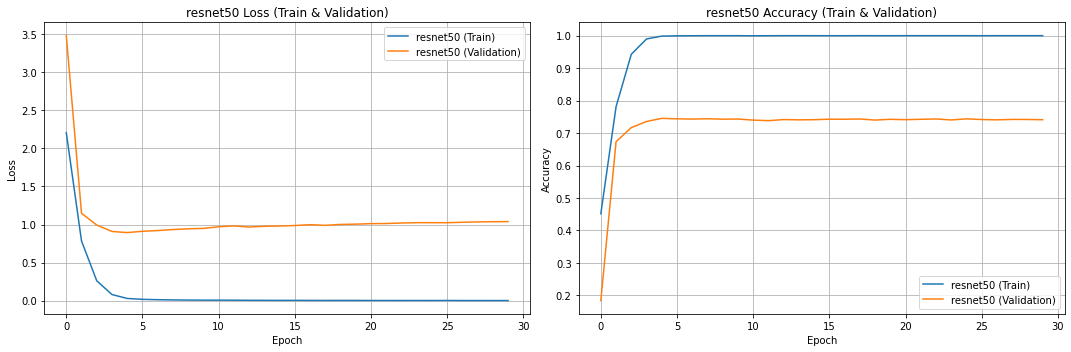  
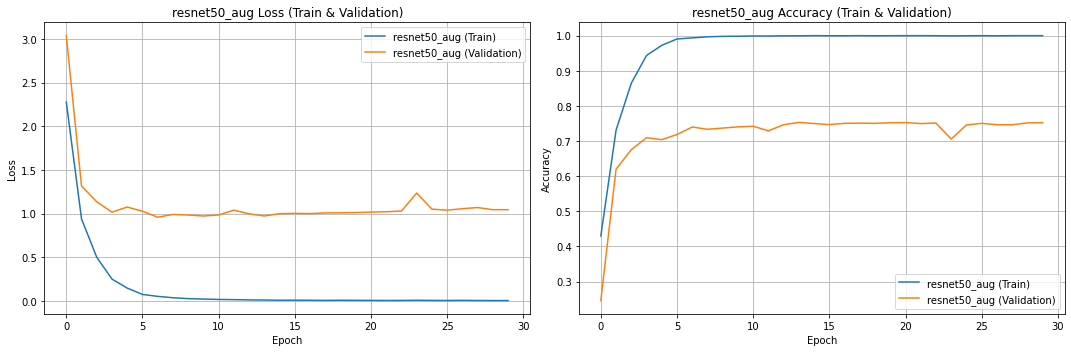  
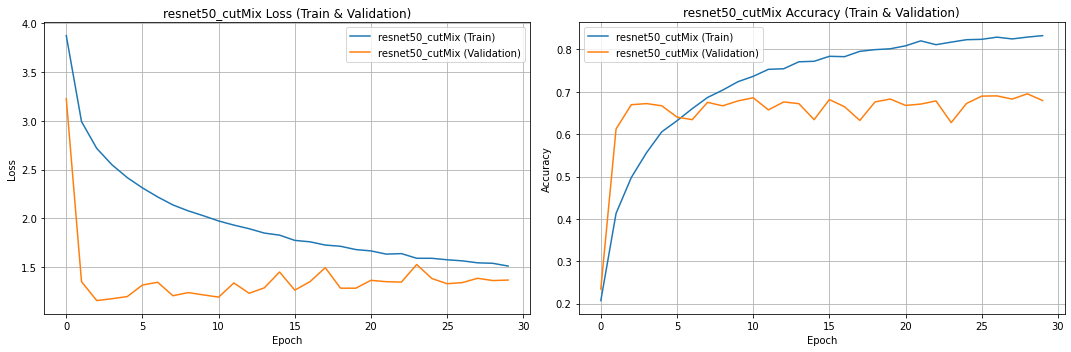  
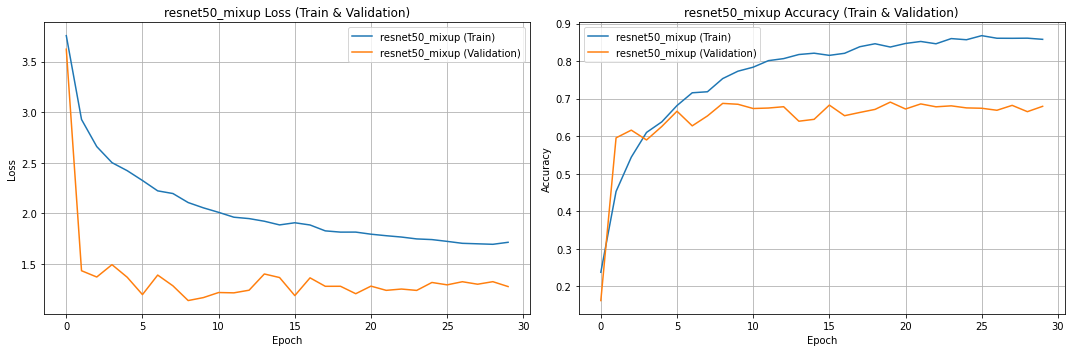
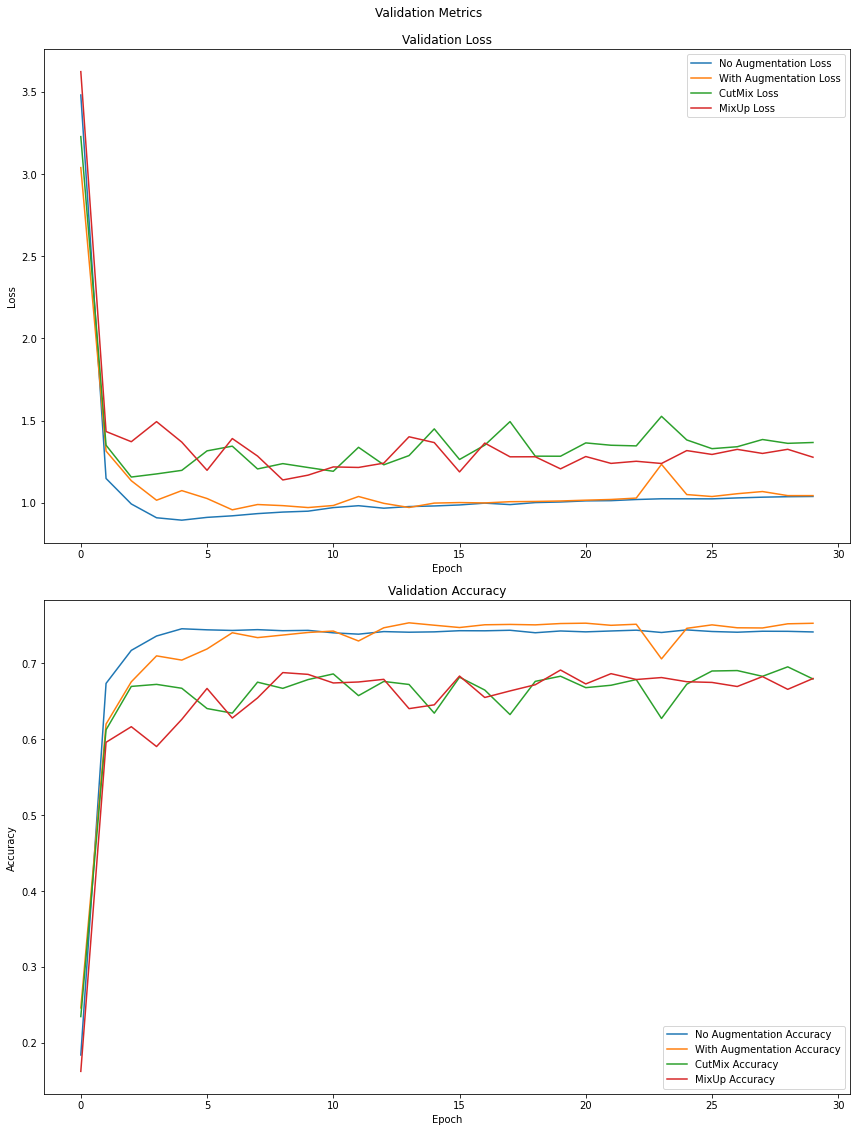
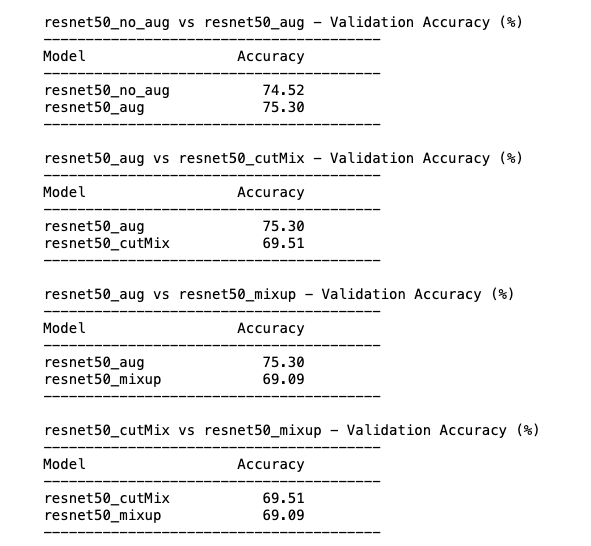

### 두번째 실험
- 학습이 전현 안되었다.
- lr 설정이 초반에 너무 크게 잡은거 같은데 다시 수정해서 3차 실험 해본다.

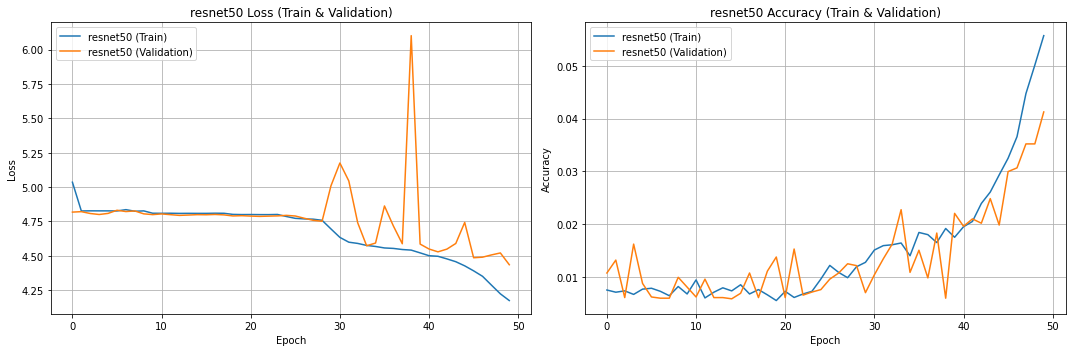
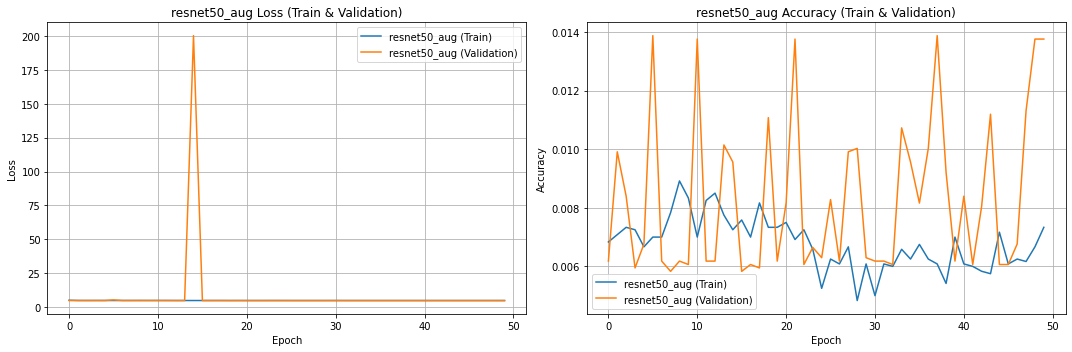
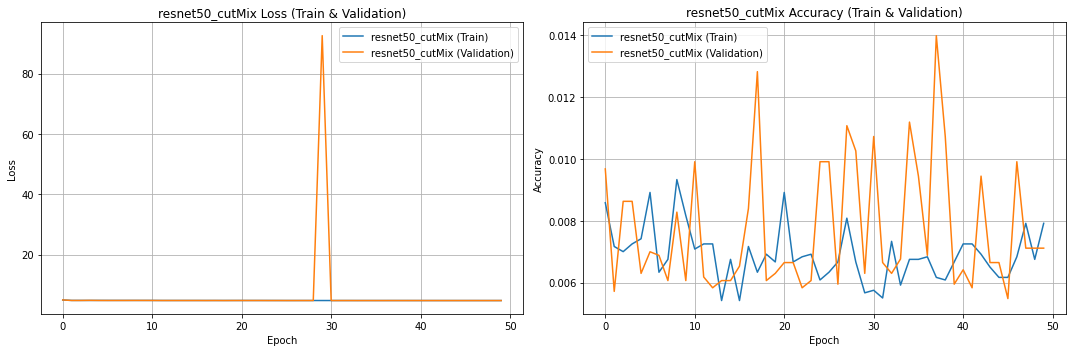
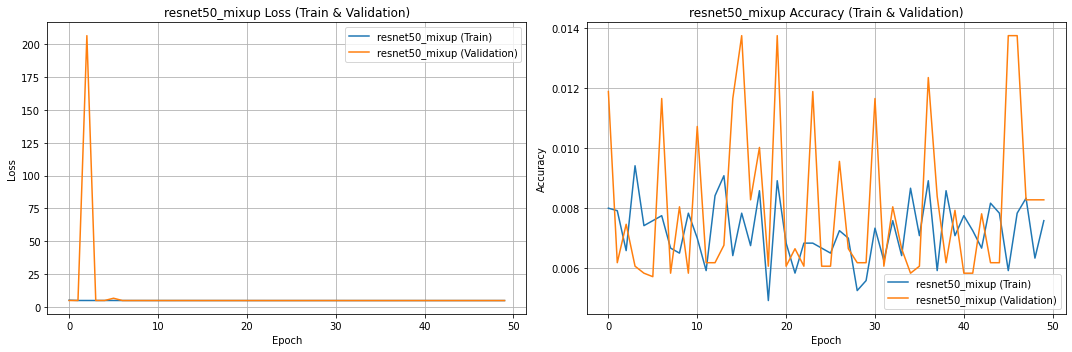
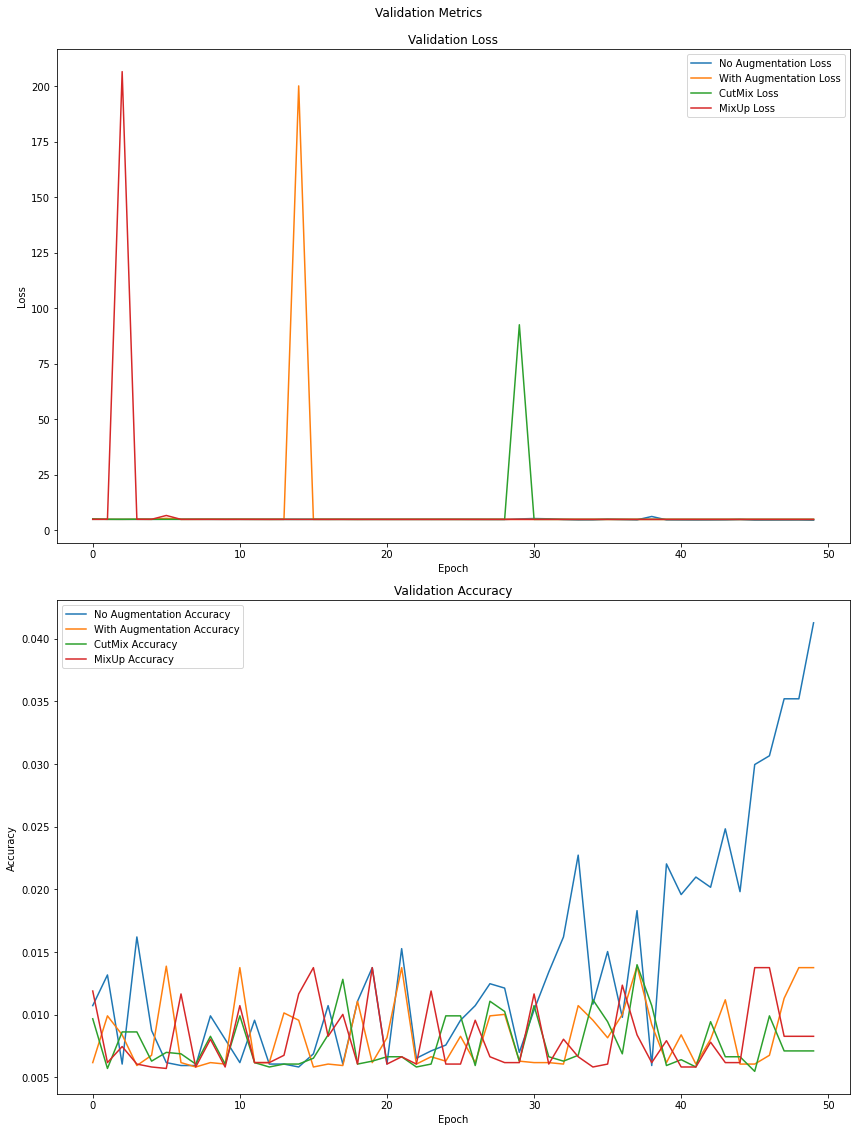
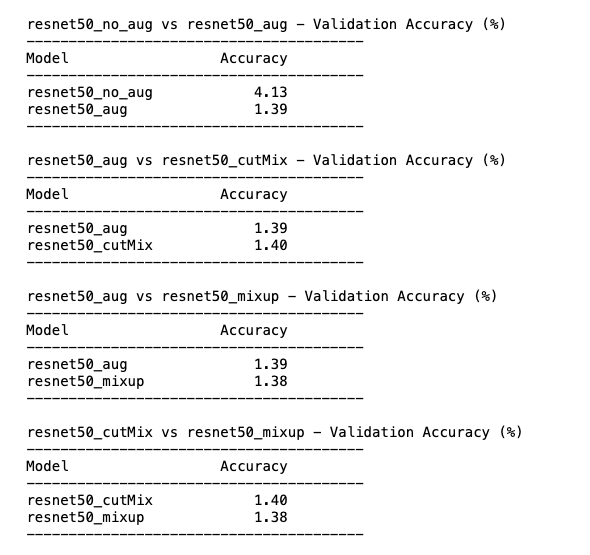

### 세번째 실험
- Adam 이 SGD 보다 성능이 안나오고 있다. 
- 실험을 중단하고 다시 SGD(momentum=0.9 적용)로 변경 후 실험 진행(나머지는 2번째와 동일하게 유지)

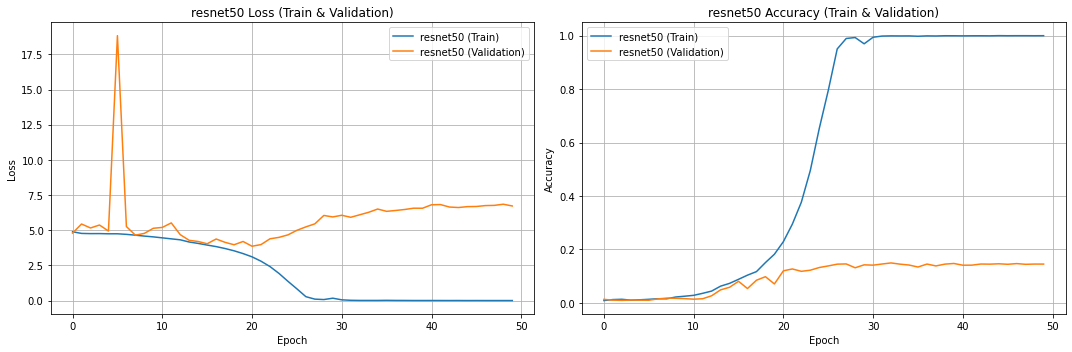

### 네번째 실험
- **history_mixup_resnet50 에서 epoch 50 까지 훈련은 되었으나 멈춰버림**
- 이번에는 cutMix 와 mixup 이 근소하게 validation 성능이 높게 나왔음

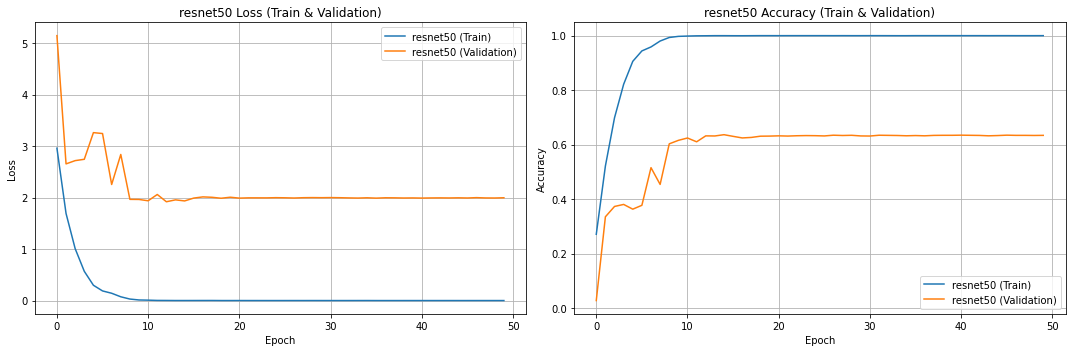
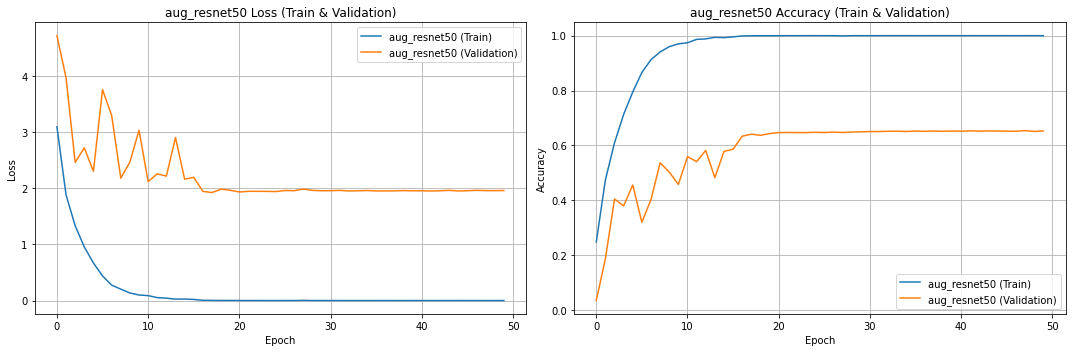
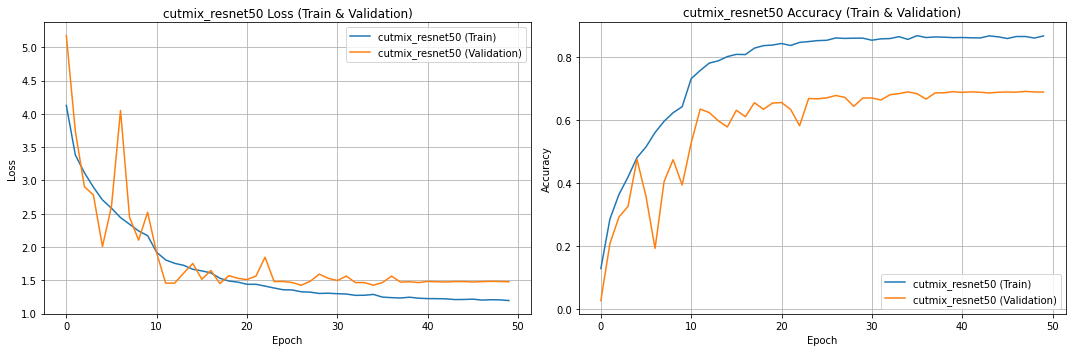  
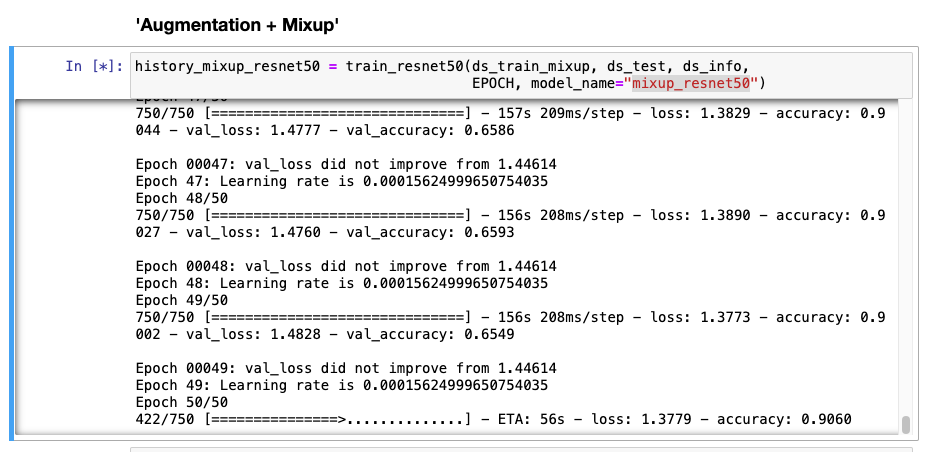
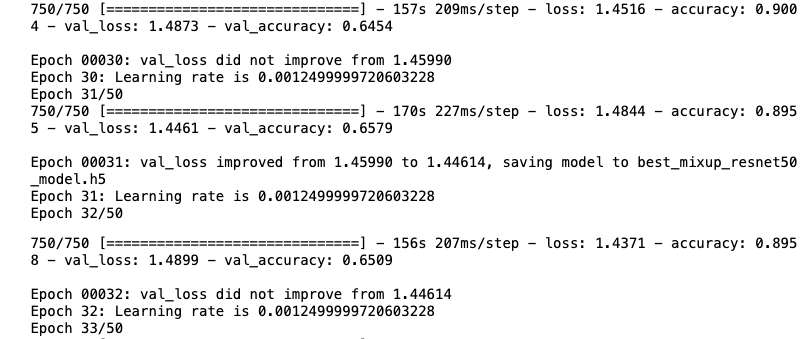

### 다섯번째 실험
- 초기 learning_rate = 0.05 에서 epoch=40 은 cutmix 나 mixup 의 경우 학습이 더 필요해 보인다.
- 0.01 보다 학습도 느리고 결과도 좋지 않다.
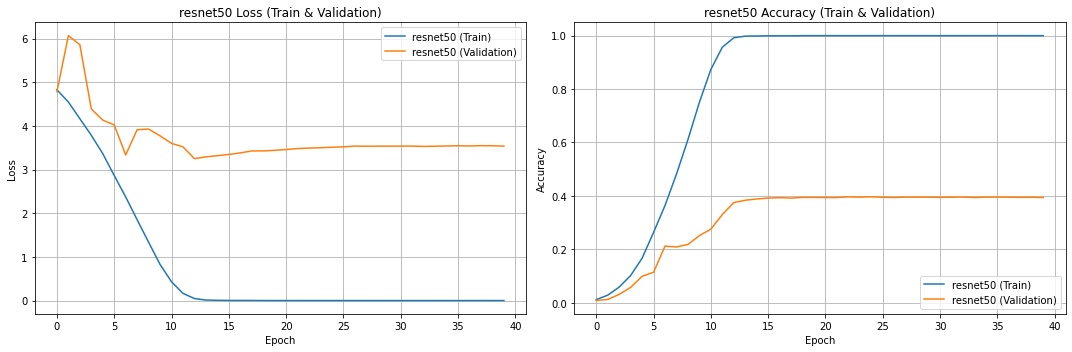
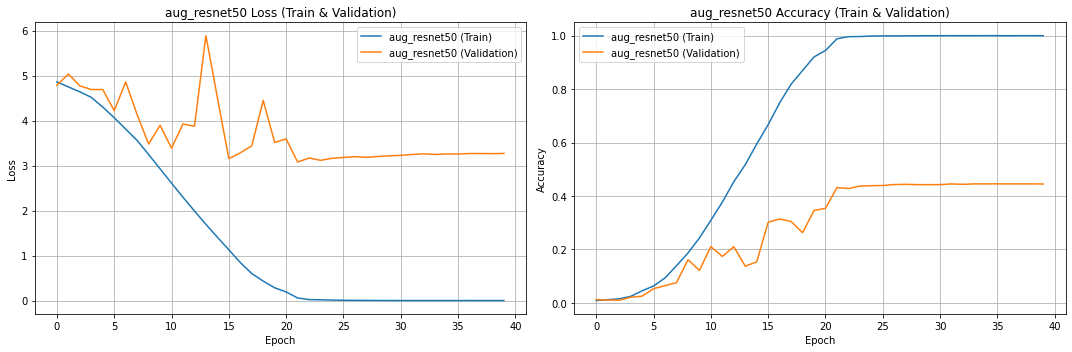
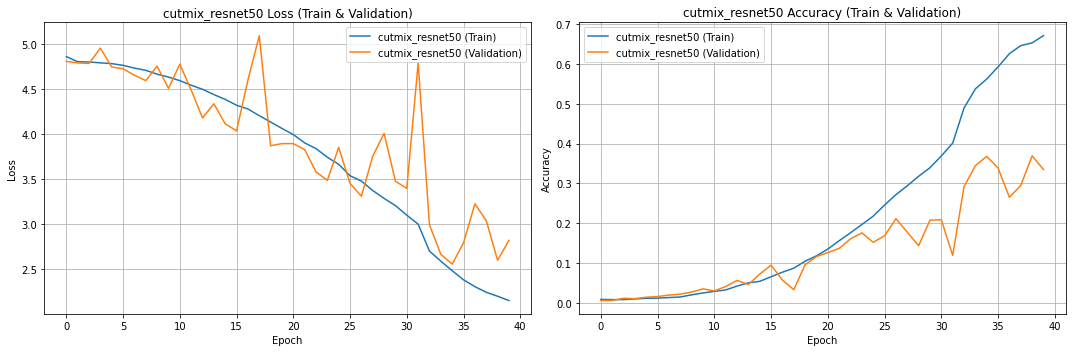
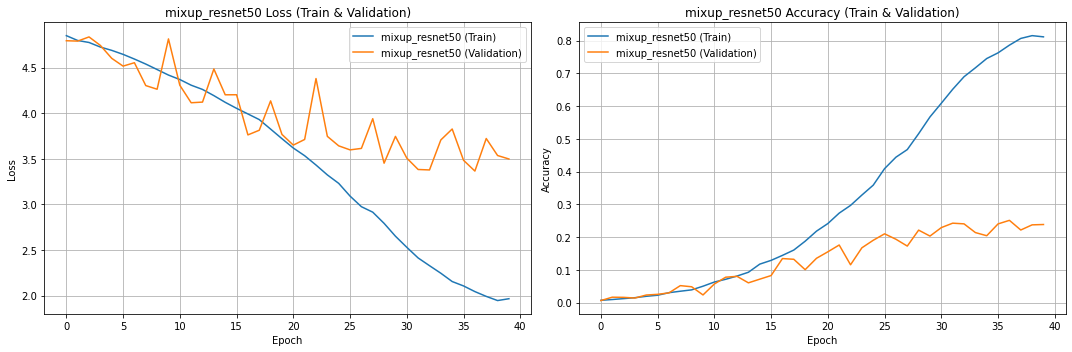
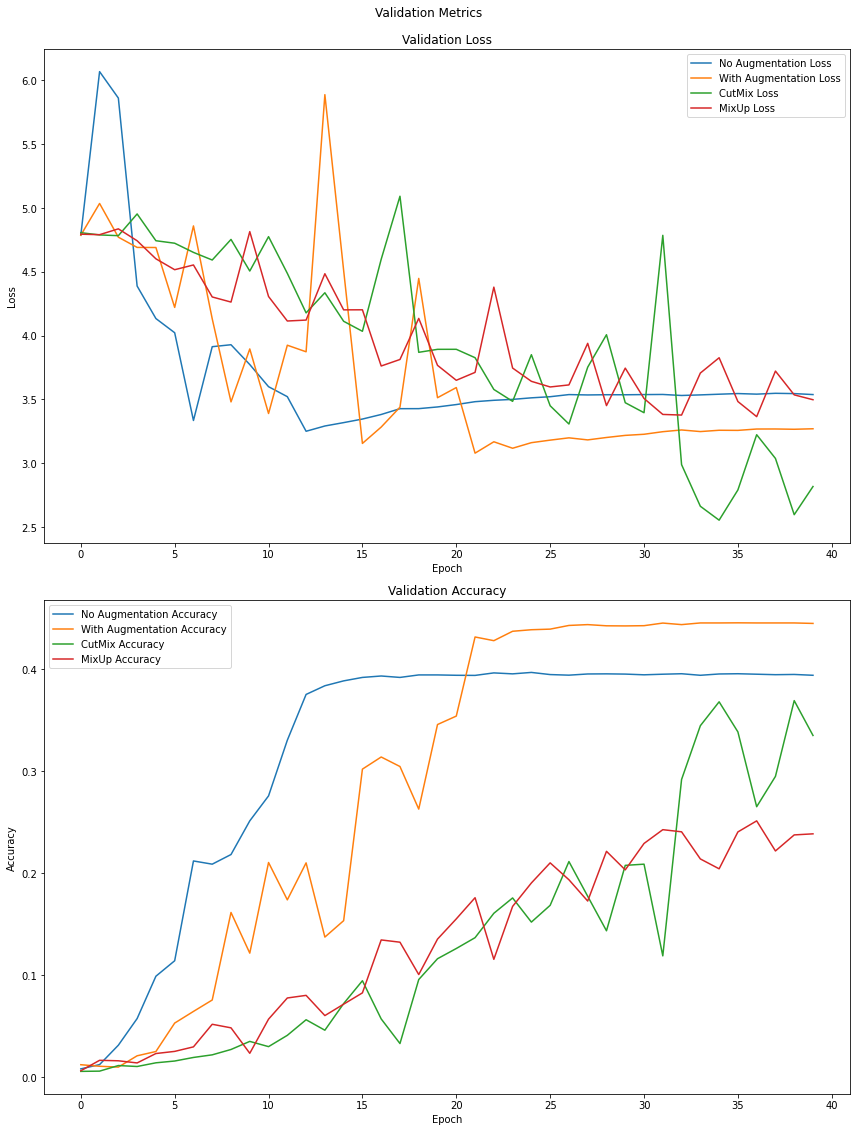
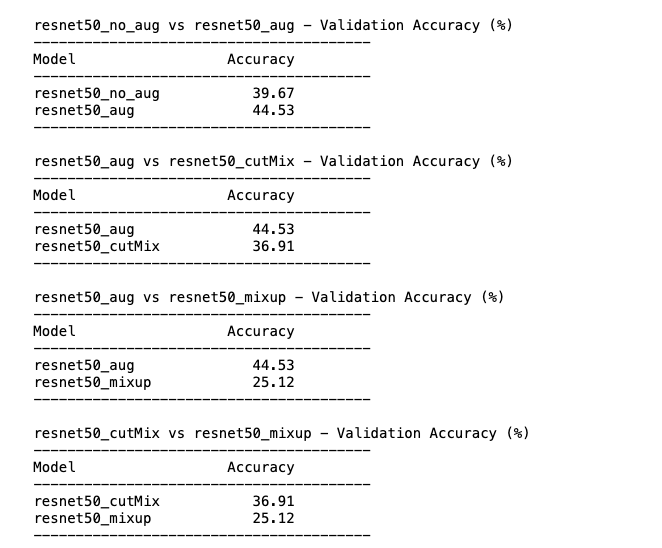

### 여섯번째 실험
- 학습 속도는 resnet50_no_aug, resnet50_aug, resnet50_cutmix, resnet50_mixup 순서대로 최적값을 찾아갔으나
- 40 epoch 이후로는 4가지 성능이 거의 비슷하게 수렴했다.
- resnet50_no_aug, resnet50_aug 은 train 과 validation loss 의 차이가 비교적 큰 반면
- resnet50_cutmix, resnet50_mixup 은 차이가 거의 없다.

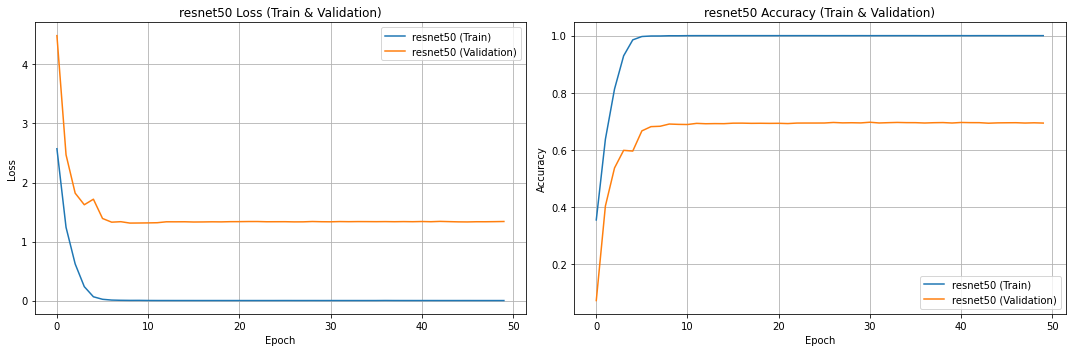
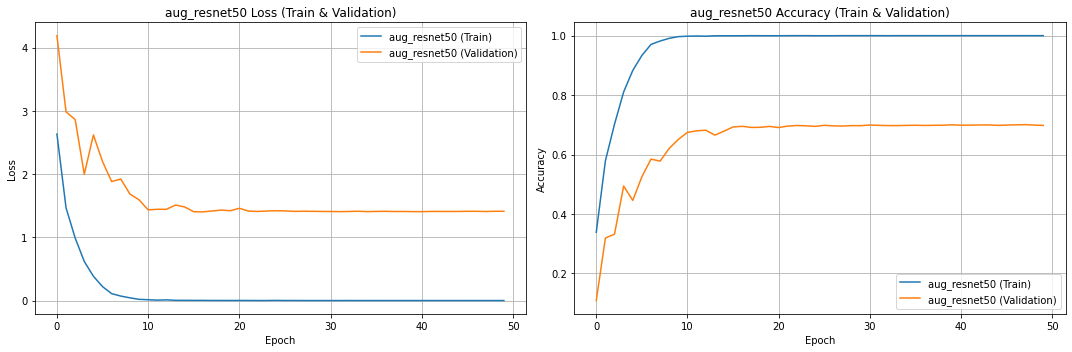
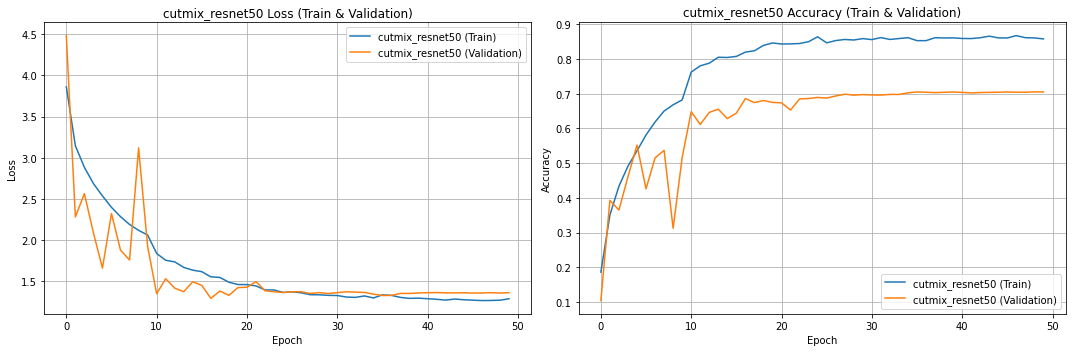
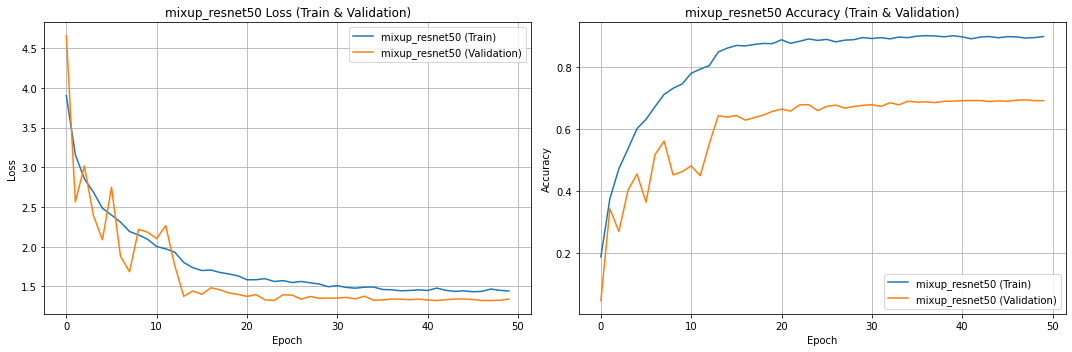
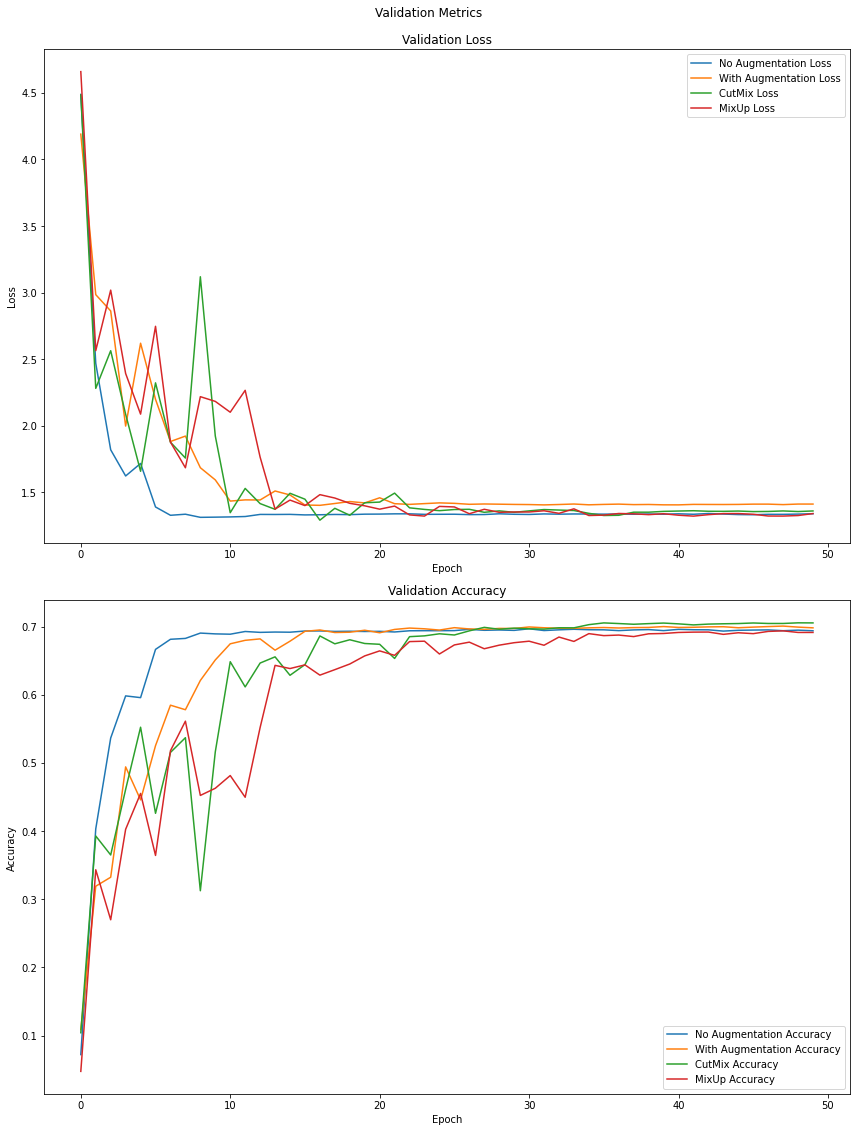
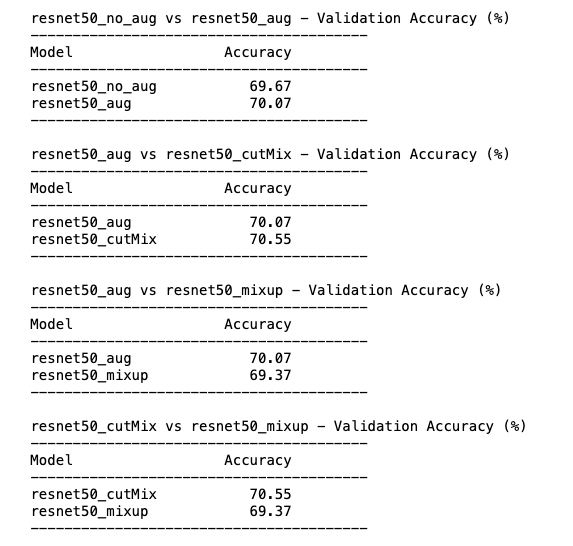

### 일곱번째 실험
- 전반적인 성능이 SGD 보다 안좋게 나왔음

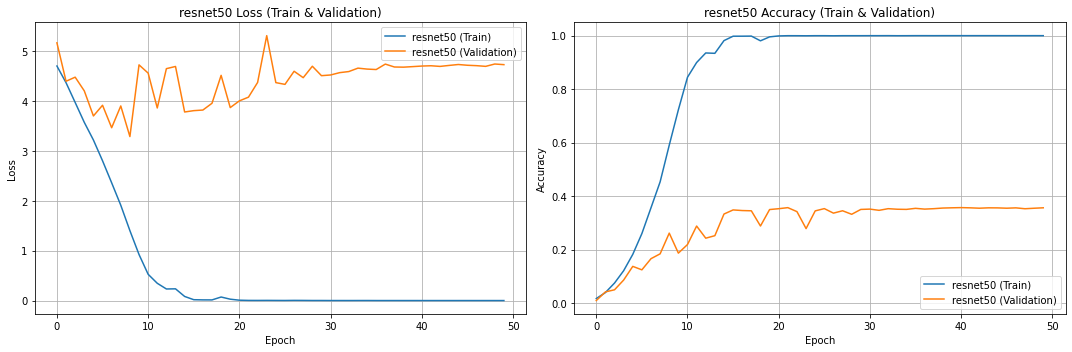
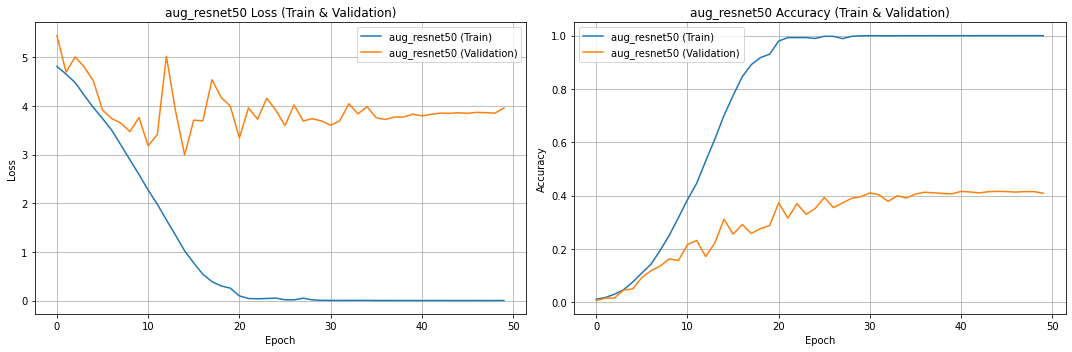
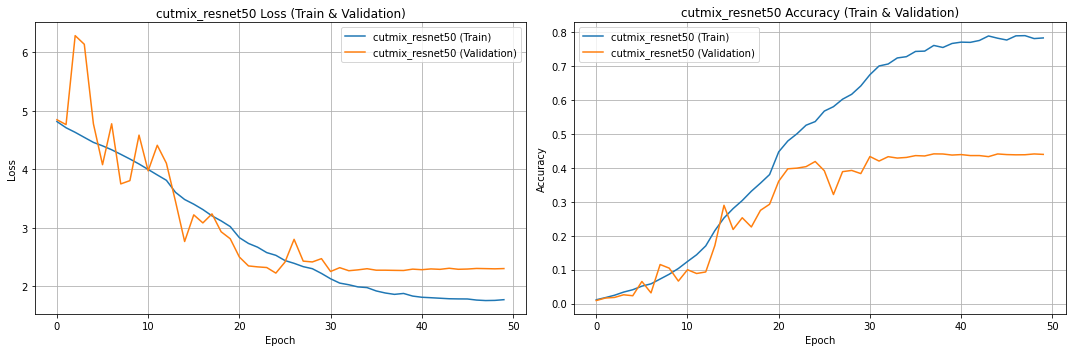
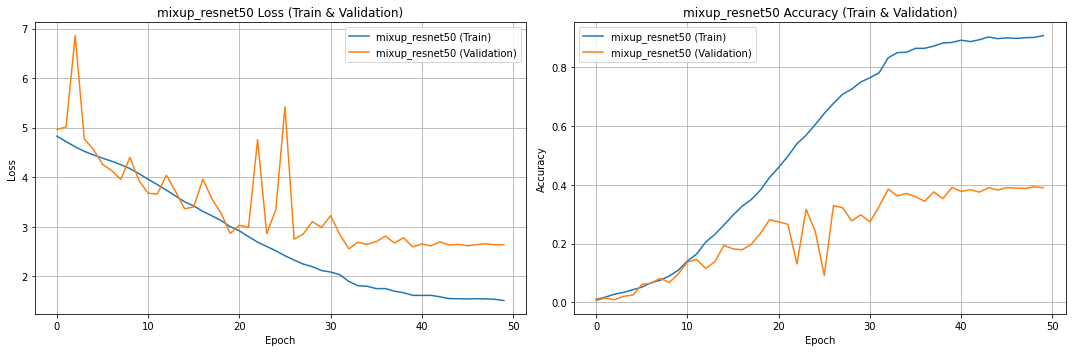
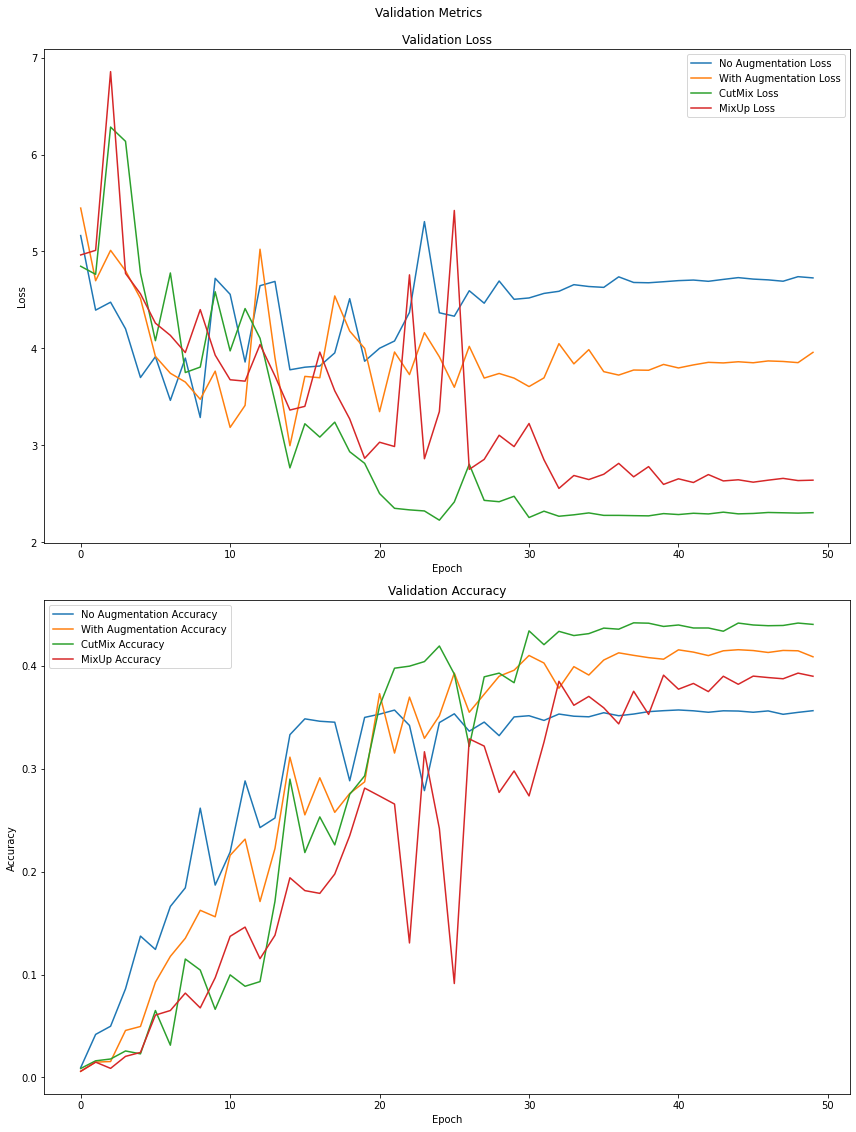
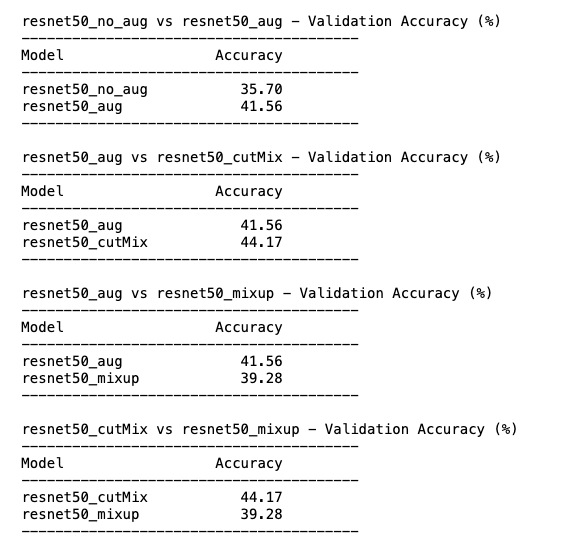

### 여덟번째 실험

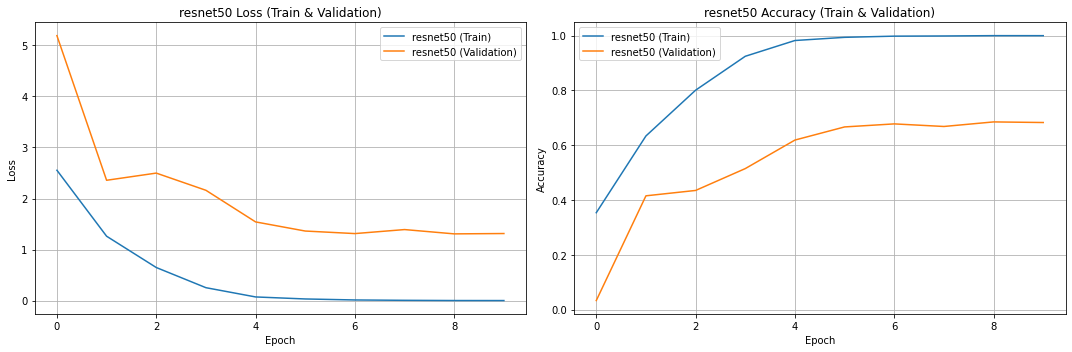
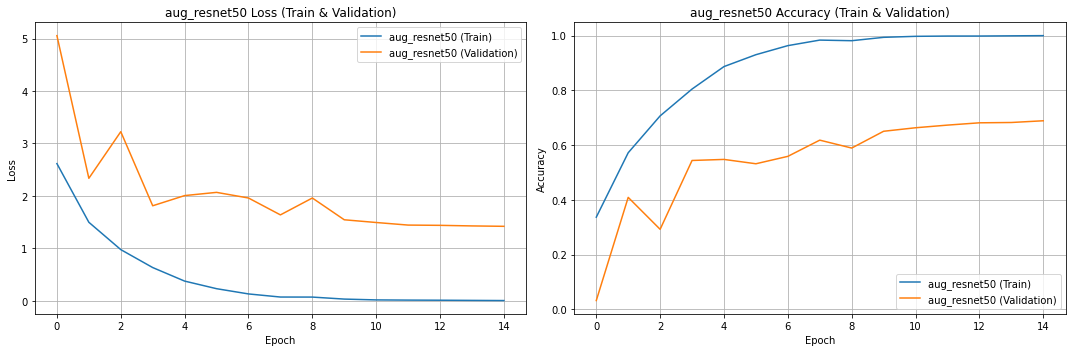
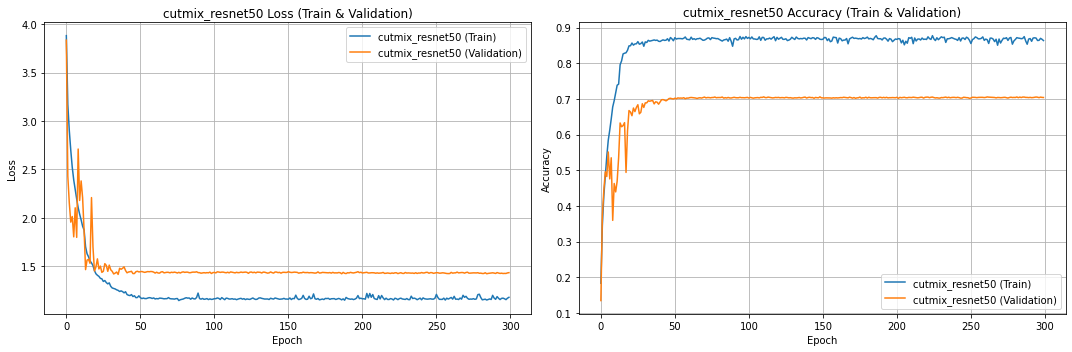
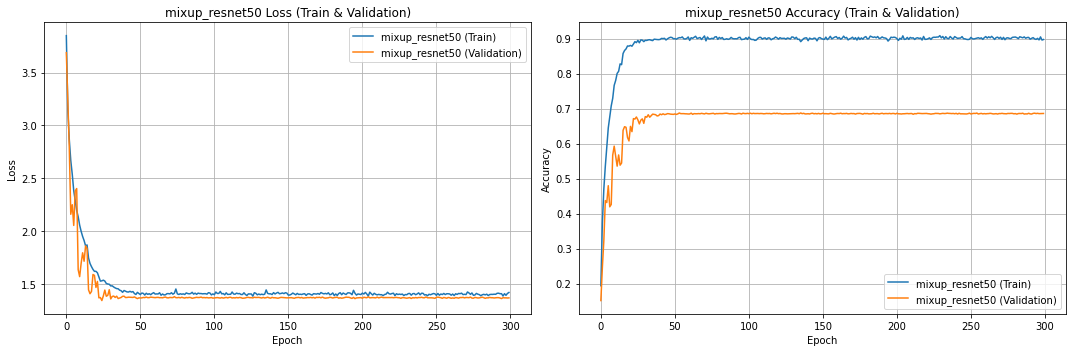
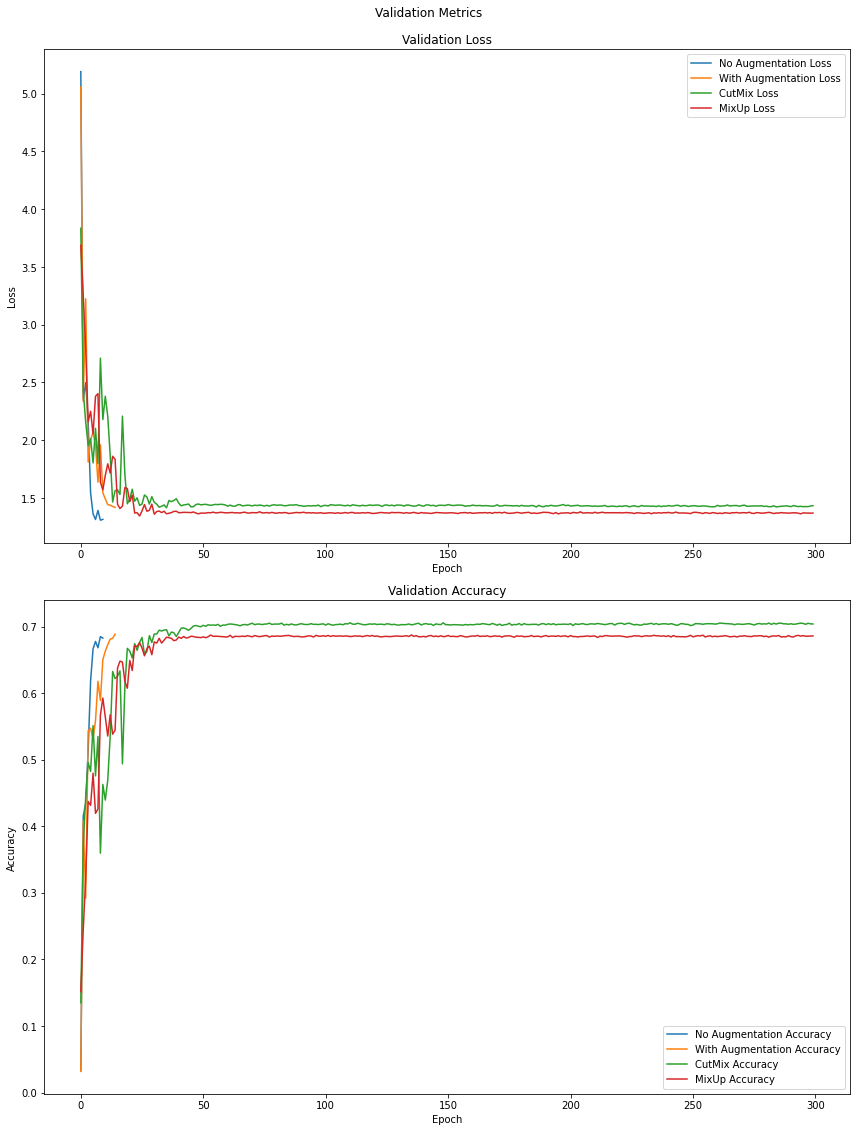
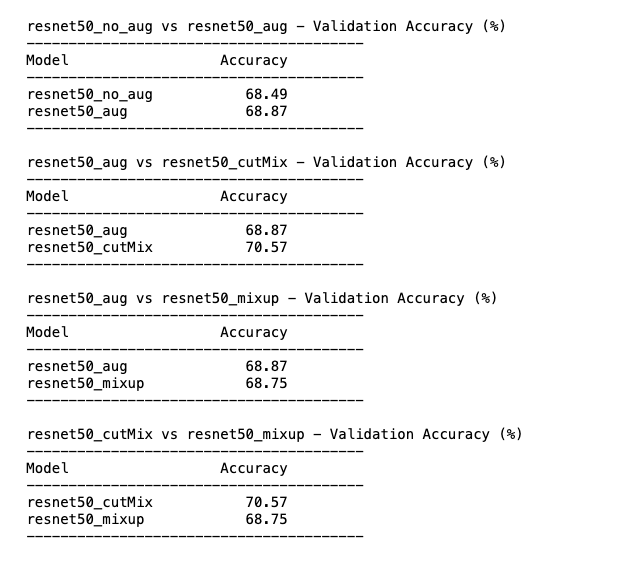

### 회고  

- accuracy 지표는 Cutmix 나 Mixup 이 조금 낮게 나왔지만 일반화 성능이 낮다라고는 할 수 없을 거 같다.
- Cutmix 나 Mixup 의 학습 속도가 일반 augmentation 보다 훨씬 느린 경향을 보이기 때문에 충분한 학습 속도가 필요 할 것으로 보인다.
- Adam 보다 SGD 가 성능이 더 좋게 나왔다.
- optimizer 나 lr 에 따라 학습에서 차이를 보였다.
- 각각의 데이터셋에 대해 epoch 수 차이를 두고 실험을 하는 것이 효율적이라고 생각이 되었다.
- random seed 를 설정 했어야 했는데 그 부분을 놓친것이 이번 실험에서 아쉬운 부분이다.

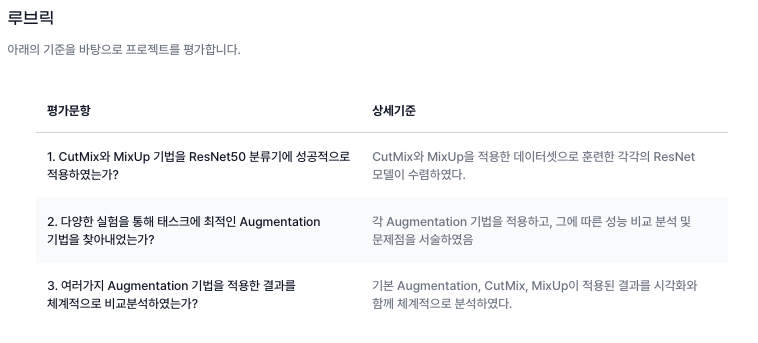